In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from random import randrange
from PIL import Image
import os
import random
from sklearn.decomposition import TruncatedSVD #importing just to do truncatedSVD for me, I didn't have the time(and energy :) ) to implement by myself.

In [2]:
#the number of classes
no_of_classes = 6

In [3]:
##k-Cross_validation_split:
def cross_validation_split(dataset,k):
    k_folds = list()
    copy_data = list(dataset)
    fold_size = int(len(dataset)/k)
    
    for i in range(k):
        fold = list()
        for j in range(fold_size):
            fold.append(copy_data.pop(randrange(len(copy_data))))
        k_folds.append(fold)
    return k_folds 

In [4]:
def one_hot_encoding(y, no_of_classes):
    y_o_h = np.zeros((1, no_of_classes))
    #print(y)
    y_o_h[0,int(y)] = 1
    return np.array(y_o_h)

In [5]:
#define sigmoid function:
def softmax(z):
    z-= np.max(z)
    activ = np.exp(z)/np.sum(np.exp(z), axis = 1, keepdims = True)
    return activ

In [6]:
def gradient_cross_entropy_loss_function(w,b,X, Y,X_t,Y_t, reg_const= 1e-2):
    
    m = X.shape[0]
    softmax_activ = softmax(np.dot(X,w) + b)
    softmax_activ_t = softmax(np.dot(X_t,w) + b)
    loss = -(1/m)*np.sum(Y*np.log(softmax_activ + 1e-6))
    loss_t = -(1/m)*np.sum(Y_t*np.log(softmax_activ_t + 1e-6))
    dw = np.dot(X.T, (softmax_activ - Y))/m
    assert(dw.shape == w.shape)
    db = np.sum(softmax_activ - Y , axis = 0, keepdims = True)/m
    assert(db.shape == b.shape)
    
    gradient = {"dw" : dw, "db" : db}
    return gradient, loss, loss_t

In [7]:
#optimize:
from tqdm import tqdm
def mini_batch_optimization(w,b,X,Y,X_t,Y_t, epoches, lr_alpha, batch_size,reg_const, algorithm):
    m = X.shape[0]
    costs = []
    costs_test = []
    for i in tqdm(range(epoches)):
        batch = np.random.choice(range(m), batch_size)
        X_batch = X[batch,:]
        Y_batch = Y[batch,:]
        gradients, cost, cost_ts = algorithm(w,b,X_batch,Y_batch,X_t, Y_t, reg_const= 1e-2)
        
        dw = gradients["dw"]
        db = gradients["db"]
        
        w = w - lr_alpha*dw
        b = b - lr_alpha*db
        if i % 100 == 0:
            costs.append(cost)
            costs_test.append(cost_ts)
        params = {"w" : w, "b" : b}
    return params, costs, costs_test

In [8]:
def prediction(w,b,X):
    m = X.shape[0] #no of data points
    Y_prediction = np.zeros((m,no_of_classes))#prediciton will be one hot encoding for each data
    w = w.reshape(X.shape[1],no_of_classes)
    b = b.reshape(1,no_of_classes)
    soft = softmax(np.dot( X,w) + b)
    #print(logit)
    for i in range(soft.shape[0]):
        index = np.argmax(soft[i,:].reshape((1, no_of_classes)))
        Y_prediction[i, index] = 1
    assert(Y_prediction.shape ==(m,no_of_classes))
    return Y_prediction

In [9]:
import os
IMAGE_PATH = './Medical_MNIST'
print(os.path.abspath(IMAGE_PATH))
n_components = 20

C:\Users\rockt\Assignment1_git\ELL409_Assignment1\Medical_MNIST


In [10]:
#data_loader
#!DEL *.npz
from tqdm import tqdm
split = 0.7 #using 70:30 split, random each time
def data_loader():
    X = []
    Y = []
    X_test = []
    Y_test = []
    
    i = 0
    for folder in os.listdir(os.path.abspath(IMAGE_PATH)):
        IMAGE_DIR = os.path.join(IMAGE_PATH, folder)
        print("Reading" + IMAGE_DIR)
        files = os.listdir(IMAGE_DIR)
        random.shuffle(files)
        j=0
        for file in tqdm(files):
            if j < int(len(files)*split):
                X.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
                Y.append(i)
            else:
                X_test.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
                Y_test.append(i)
            j += 1
        
        i += 1
    print('Completed Loading Data. Saving as np file so that can directy load array nexttime')
    np.savez('q3data.npz', X = np.array(X), Y = np.array(Y), X_test=X_test, Y_test = Y_test)
    return np.array(X), np.array(Y), np.array(X_test), np.array(Y_test)

if 'q3data.npz' in os.listdir('./'):
    zfile = np.load('q3data.npz')
    X = zfile['X']
    Y = zfile['Y']
    X_test = zfile['X_test']
    Y_test = zfile['Y_test']
else:
    X, Y, X_test, Y_test = data_loader()

In [11]:
#Lets try to do PCA on the input images??
h, w = 64, 64
'''
def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    
    return projected, components, mean, centered_data
    #credits to https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184 for helping me write PCA
    #and saving me a few hours.
'''
"""It helps visualising the portraits from the dataset."""
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
'''
n_components = 50
P, C, M, X_centered=pca(X[:1000], n_pc=n_components)
#P->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)
eigenscans = C.reshape((n_components, h, w))
eigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]
plot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) 
'''

'\nn_components = 50\nP, C, M, X_centered=pca(X[:1000], n_pc=n_components)\n#P->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)\neigenscans = C.reshape((n_components, h, w))\neigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]\nplot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) \n'

In [12]:
X_samples = list()
Y_samples = list()
X_samples.append(list(X))
Y_samples.append(list(Y))
X_samples.append(list(X_test))
Y_samples.append(list(Y_test))
X_samples = sum(X_samples, [])
Y_samples = sum(Y_samples, [])
X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

In [13]:
def fastpca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    svd = TruncatedSVD(n_components=n_pc, n_iter=7, random_state=42)
    svd.fit(X)
    #U, S, V = np.linalg.svd(centered_data)
    components = svd.components_
    #projected = U[:,:n_pc]*S[:n_pc]
    projected = svd.transform(X)
    return projected, components, mean, centered_data

In [14]:
X_red, C, M, X_centered=fastpca(X_samples, n_pc=n_components)
#X_red->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)
#eigenscans = C.reshape((n_components, h, w))
#eigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]
#plot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) 

In [15]:
Y_samples = Y_samples.reshape((58954,1))

In [16]:
X_final = np.append(X_red, Y_samples, axis = 1)
X_final.shape

(58954, 21)

In [17]:
no_of_classes = 6

In [18]:
int(Y_samples[58931,:])

5

In [19]:
type(Y_samples)
Y

array([0, 0, 0, ..., 5, 5, 5])

In [20]:
k_folds = cross_validation_split(X_final, 5)

In [21]:
X_test = k_folds[0]
X_test = np.array(X_test)
print(X_test.shape)

(11790, 21)


In [22]:
X_train = list(k_folds)
#print(ind)
del X_train[0]
X_train = sum(X_train, [])
X_train = np.array(X_train)

In [23]:
X_train_f = X_train[:, :20]
X_test_f = X_test[:,:20]
Y_train_f = X_train[:,20].reshape(X_train.shape[0],1)
Y_test_f = X_test[:,20].reshape(X_test.shape[0],1)

In [24]:
Y_test_f

array([[3.],
       [0.],
       [3.],
       ...,
       [4.],
       [4.],
       [5.]])

In [25]:
Y_tr = np.zeros((Y_train_f.shape[0], no_of_classes))
for i in range(Y_train_f.shape[0]):
    Y_tr[i,:] = one_hot_encoding(int(Y_train_f[i,:]), no_of_classes)

In [26]:
Y_ts = np.zeros((Y_test_f.shape[0], no_of_classes))
for i in range(Y_test_f.shape[0]):
    Y_ts[i,:] = one_hot_encoding(int(Y_test_f[i,:]), no_of_classes)

In [27]:
w = np.zeros(( X_train_f.shape[1], no_of_classes))
b = np.zeros((1, no_of_classes))

In [28]:
parameters, costs = mini_batch_optimization(w, b, X_train_f, Y_tr, 10000, 0.0000005,1000)

TypeError: mini_batch_optimization() missing 4 required positional arguments: 'lr_alpha', 'batch_size', 'reg_const', and 'algorithm'

array([1.79175347, 0.15113347, 0.17039531, 0.12058524, 0.13030403,
       0.1183173 , 0.0905454 , 0.12127021, 0.11111277, 0.14599253])

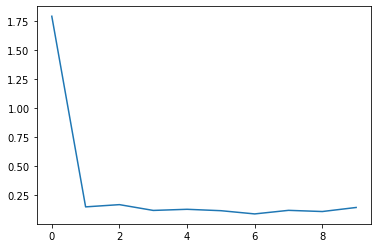

In [107]:
costs = np.squeeze(costs)
plt.plot(costs)
costs

In [29]:
def model(w,b ,X_train, Y_train, X_test, Y_test,algorithm, epoches = 10000, learning_rate = 0.0005, batch_size = 1000,reg_const= 1e-2):
    w = np.zeros(( X_train.shape[1], no_of_classes))
    b = np.zeros((1, no_of_classes))
    parameters, costs, cost_test = mini_batch_optimization(w, b, X_train, Y_train, X_test, Y_test, epoches, learning_rate,batch_size,reg_const, algorithm)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = prediction(w, b, X_test)
    Y_prediction_train = prediction(w, b, X_train)
    print(Y_prediction_train.shape)
    print(Y_prediction_test.shape)
    tr_m = Y_train.shape[0]
    ts_m = Y_test.shape[0]
    print("train accuracy: {} %".format(100 -(1/(2*tr_m))*np.sum(np.abs(Y_prediction_train[:,:] - Y_train[:,:])) * 100))
    print("test accuracy: {} %".format(100 - (1/(2*ts_m))*np.sum(np.abs(Y_prediction_test[:,:] - Y_test[:,:])) * 100))
    
    
    d = {"costs": costs,
         "costs_test": cost_test,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": epoches}
    
    return d

In [30]:
d = model(w, b, X_train_f, Y_tr,X_test_f, Y_ts,gradient_cross_entropy_loss_function, 20000, 0.0000005,1000,1e-2)

 38%|███▊      | 7591/20000 [02:35<07:13, 28.59it/s]

KeyboardInterrupt: 

In [83]:
Y_pred = np.array(d["Y_prediction_test"])
C = np.zeros((no_of_classes, no_of_classes))
i = 0
print(Y_test_f.shape)
print(Y_test_f)
for y in Y_test_f:
    index1 = np.argmax(Y_pred[i])
    index2 = int(Y_test_f[i,:])
    #print(index2)
    C[index1 , index2] +=1
    i+=1
C

(11790, 1)
[[5.]
 [2.]
 [2.]
 ...
 [3.]
 [1.]
 [2.]]


array([[1883.,    0.,   15.,    6.,   14.,   10.],
       [   0., 1797.,    0.,    0.,    0.,    0.],
       [  66.,    0., 1960.,    8.,    3.,   87.],
       [   0.,    0.,    0., 1983.,   14.,    3.],
       [   0.,    0.,    0.,   15., 1941.,   61.],
       [   0.,    0.,    0.,    8.,   66., 1850.]])

In [31]:
C = np.array([[1883.,    0.,   15.,    6.,   14.,   10.],
       [   0., 1797.,    0.,    0.,    0.,    0.],
       [  66.,    0., 1960.,    8.,    3.,   87.],
       [   0.,    0.,    0., 1983.,   14.,    3.],
       [   0.,    0.,    0.,   15., 1941.,   61.],
       [   0.,    0.,    0.,    8.,   66., 1850.]])

In [32]:
conf = C
conf_ = C.T
n_classes = 6

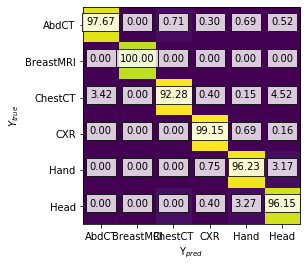

In [33]:
plt.imshow(conf.T/np.sum(conf))
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float((conf[i][j]/np.sum(conf[j]))*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

In [34]:

diag = np.arange(n_classes)
acc = np.sum(conf[diag, diag])/np.sum(conf)*100

print('Accuracy = {:0.2f}'.format(acc))

#per class precision, recall
P = []
R = []
F = []
for i in range(n_classes):
    P.append(conf_[i,i]/np.sum(conf_[i,:]))
    R.append(conf_[i,i]/np.sum(conf_[:,i]))
    F.append(2*P[i]*R[i]/(P[i] + R[i]))
    print('{}: p = {:0.3f}, r = {:0.3f}, f = {:0.3f}'.format(classes[i], P[i]*100, R[i]*100, F[i]*100))
macro_f = sum(F)/len(F)
print('Macro-F1 score = {:0.3f}'.format(macro_f*100))

Accuracy = 96.81
AbdCT: p = 96.614, r = 97.666, f = 97.137
BreastMRI: p = 100.000, r = 100.000, f = 100.000
ChestCT: p = 99.241, r = 92.279, f = 95.633
CXR: p = 98.168, r = 99.150, f = 98.657
Hand: p = 95.240, r = 96.232, f = 95.734
Head: p = 91.994, r = 96.154, f = 94.028
Macro-F1 score = 96.865


 38%|███▊      | 7591/20000 [02:50<07:13, 28.59it/s]

In [84]:
Y_pred = np.array(d["Y_prediction_train"])
C = np.zeros((no_of_classes, no_of_classes))
i = 0
for y in Y_train_f:
    index1 = np.argmax(Y_pred[i])
    index2 = int(Y_train_f[i,:])
    C[index1 , index2] +=1
    i+=1
C

array([[7.860e+03, 0.000e+00, 7.000e+01, 1.800e+01, 4.800e+01, 1.800e+01],
       [0.000e+00, 7.154e+03, 0.000e+00, 3.000e+00, 7.000e+00, 2.000e+00],
       [1.900e+02, 0.000e+00, 7.954e+03, 2.800e+01, 2.100e+01, 2.990e+02],
       [0.000e+00, 2.000e+00, 0.000e+00, 7.873e+03, 4.100e+01, 1.100e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, 4.200e+01, 7.604e+03, 2.050e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, 1.500e+01, 2.410e+02, 7.454e+03]])

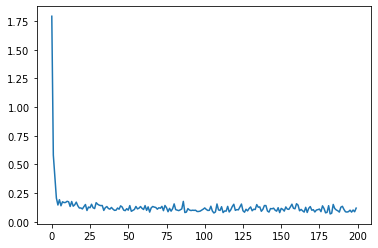

In [55]:
costs = np.squeeze(d['costs'])
plt.plot(costs)

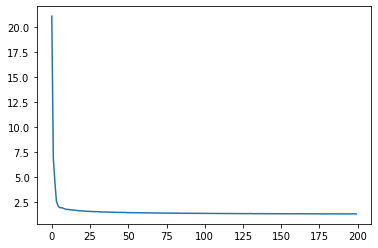

In [54]:
costs02 = np.squeeze(d['costs_test'])
plt.plot(costs02)

# L1

In [39]:
d1 = model(w, b, X_train_f, Y_tr,X_test_f, Y_ts,gradient_cross_entropy_loss_function_L1, 20000, 0.0000005,1000,1e-2)


  4%|▍         | 882/20000 [00:16<05:10, 61.65it/s]


  9%|▉         | 1815/20000 [00:33<05:43, 53.00it/s]


 13%|█▎        | 2657/20000 [00:49<07:49, 36.93it/s]


 17%|█▋        | 3326/20000 [01:07<05:28, 50.70it/s]


 21%|██        | 4204/20000 [01:23<07:34, 34.79it/s]


 25%|██▌       | 5030/20000 [01:40<10:06, 24.70it/s]


 28%|██▊       | 5700/20000 [01:57<05:07, 46.44it/s]


 33%|███▎      | 6542/20000 [02:14<04:21, 51.40it/s]


 36%|███▋      | 7283/20000 [02:31<08:54, 23.80it/s]


 41%|████      | 8154/20000 [02:47<03:35, 54.89it/s]


 45%|████▌     | 9071/20000 [03:04<03:27, 52.76it/s]


 49%|████▉     | 9794/20000 [03:21<03:41, 46.04it/s]


 53%|█████▎    | 10683/20000 [03:37<02:40, 58.02it/s]


 57%|█████▋    | 11336/20000 [03:53<04:20, 33.31it/s]


 61%|██████    | 12232/20000 [04:09<02:10, 59.44it/s]


 65%|██████▌   | 13088/20000 [04:25<02:29, 46.15it/s]


 69%|██████▉   | 13847/20000 [04:42<01:54, 53.82it/s]


 73%|███████▎  | 14659/20000 [04:58<02:08, 41.56it/s]


 77%|███████▋  | 15466/20000 [05:14<01:27, 51.94it/s]


 82%|████████▏ | 16309/20000 [05:31<01:20, 45.85it/s]


 85%|████████▌ | 17021/20000 [05:47<00:56, 52.27it/s]


 89%|████████▉ | 17880/20000 [06:03<00:40, 52.75it/s]


 93%|█████████▎| 18556/20000 [06:21<00:25, 56.20it/s]


 97%|█████████▋| 19384/20000 [06:37<00:13, 46.78it/s]


100%|██████████| 20000/20000 [06:51<00:00, 48.66it/s]


(47160, 6)
(11790, 6)
train accuracy: 97.09923664122138 %
test accuracy: 97.23494486853265 %


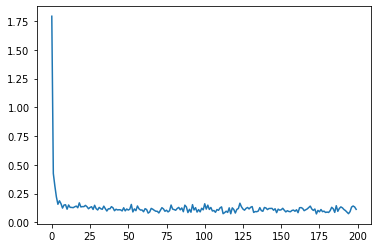

In [61]:
costs11 = np.squeeze(d1['costs'])
plt.plot(costs11)

In [40]:
Y_pred = np.array(d1["Y_prediction_test"])
C1 = np.zeros((no_of_classes, no_of_classes))
i = 0
print(Y_test_f.shape)
print(Y_test_f)
for y in Y_test_f:
    index1 = np.argmax(Y_pred[i])
    index2 = int(Y_test_f[i,:])
    #print(index2)
    C1[index1 , index2] +=1
    i+=1
C1

(11790, 1)
[[3.]
 [0.]
 [3.]
 ...
 [4.]
 [4.]
 [5.]]


array([[1.926e+03, 0.000e+00, 2.200e+01, 5.000e+00, 8.000e+00, 7.000e+00],
       [0.000e+00, 1.815e+03, 0.000e+00, 0.000e+00, 4.000e+00, 1.000e+00],
       [5.100e+01, 0.000e+00, 2.009e+03, 9.000e+00, 6.000e+00, 6.900e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, 1.984e+03, 1.000e+01, 3.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 1.100e+01, 1.883e+03, 6.300e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 5.100e+01, 1.847e+03]])

In [41]:
conf = C1
conf_ = C1.T
n_classes = 6

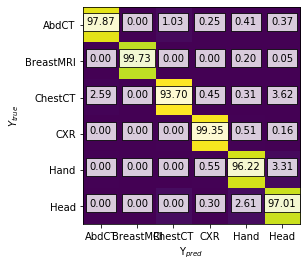

In [42]:
plt.imshow(conf.T/np.sum(conf))
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float((conf[i][j]/np.sum(conf[j]))*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

In [43]:

diag = np.arange(n_classes)
acc = np.sum(conf[diag, diag])/np.sum(conf)*100

print('Accuracy = {:0.2f}'.format(acc))

#per class precision, recall
P = []
R = []
F = []
for i in range(n_classes):
    P.append(conf_[i,i]/np.sum(conf_[i,:]))
    R.append(conf_[i,i]/np.sum(conf_[:,i]))
    F.append(2*P[i]*R[i]/(P[i] + R[i]))
    print('{}: p = {:0.3f}, r = {:0.3f}, f = {:0.3f}'.format(classes[i], P[i]*100, R[i]*100, F[i]*100))
macro_f = sum(F)/len(F)
print('Macro-F1 score = {:0.3f}'.format(macro_f*100))

Accuracy = 97.23
AbdCT: p = 97.420, r = 97.866, f = 97.643
BreastMRI: p = 100.000, r = 99.725, f = 99.862
ChestCT: p = 98.917, r = 93.703, f = 96.240
CXR: p = 98.462, r = 99.349, f = 98.903
Hand: p = 95.973, r = 96.219, f = 96.096
Head: p = 92.814, r = 97.006, f = 94.864
Macro-F1 score = 97.268


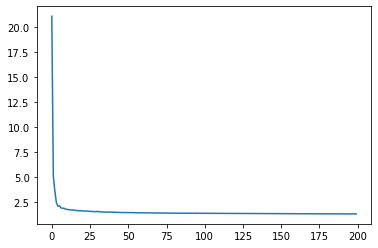

In [62]:
costs12 = np.squeeze(d1['costs_test'])
plt.plot(costs12)

# L2

In [63]:
d2 = model(w, b, X_train_f, Y_tr,X_test_f, Y_ts,gradient_cross_entropy_loss_function_L2, 20000, 0.0000005,1000,1e-2)


  4%|▍         | 892/20000 [00:36<13:18, 23.94it/s]


  9%|▉         | 1780/20000 [01:11<11:20, 26.76it/s]


 21%|██        | 4172/20000 [01:44<03:28, 76.00it/s]


 33%|███▎      | 6590/20000 [02:16<03:02, 73.46it/s]


 45%|████▍     | 8957/20000 [02:49<02:33, 72.07it/s]


 51%|█████     | 10142/20000 [03:06<02:18, 71.43it/s]


 62%|██████▏   | 12381/20000 [03:38<02:01, 62.83it/s]


 73%|███████▎  | 14520/20000 [04:11<01:23, 65.64it/s]


 83%|████████▎ | 16688/20000 [04:43<00:46, 70.67it/s]


 94%|█████████▍| 18809/20000 [05:16<00:17, 67.04it/s]


100%|██████████| 20000/20000 [05:34<00:00, 59.87it/s]


(47160, 6)
(11790, 6)
train accuracy: 97.33460559796438 %
test accuracy: 96.86174724342663 %


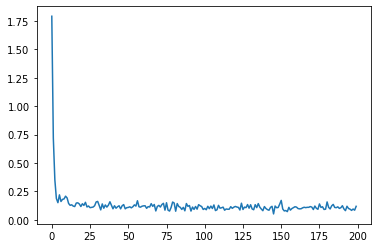

In [64]:
costs21 = np.squeeze(d2['costs'])
plt.plot(costs21)

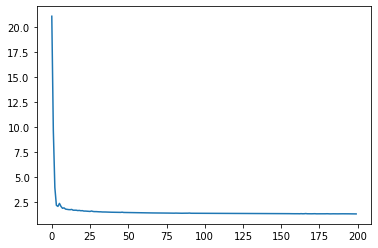

In [65]:
costs22 = np.squeeze(d2['costs_test'])
plt.plot(costs22)

# Elastic

In [66]:
d3 = model(w, b, X_train_f, Y_tr,X_test_f, Y_ts,gradient_cross_entropy_loss_function_elastic, 20000, 0.0000005,1000,1e-2)


 10%|█         | 2004/20000 [00:33<04:32, 66.12it/s]


 19%|█▉        | 3886/20000 [01:06<05:55, 45.35it/s]


 29%|██▉       | 5784/20000 [01:39<04:40, 50.77it/s]


 38%|███▊      | 7639/20000 [02:13<03:41, 55.81it/s]


 46%|████▌     | 9162/20000 [02:48<04:03, 44.53it/s]


 55%|█████▍    | 10926/20000 [03:21<04:13, 35.73it/s]


 65%|██████▍   | 12934/20000 [03:54<01:50, 63.81it/s]


 74%|███████▍  | 14813/20000 [04:27<01:17, 67.13it/s]


 83%|████████▎ | 16655/20000 [05:00<00:56, 59.33it/s]


 93%|█████████▎| 18539/20000 [05:33<00:22, 65.35it/s]


100%|██████████| 20000/20000 [05:57<00:00, 55.98it/s]


(47160, 6)
(11790, 6)
train accuracy: 97.28371501272265 %
test accuracy: 96.77692960135708 %


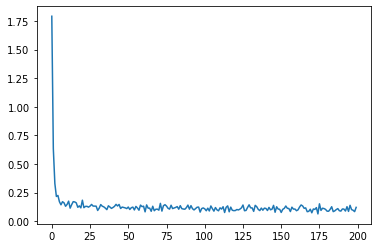

In [67]:
costs31 = np.squeeze(d3['costs'])
plt.plot(costs31)

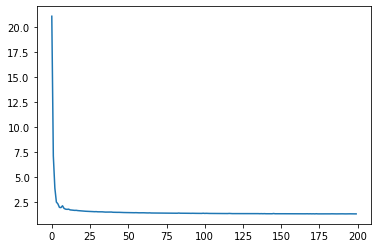

In [68]:
costs32= np.squeeze(d3['costs_test'])
plt.plot(costs32)

# L2 regularizers

In [56]:
def gradient_cross_entropy_loss_function_L2(w,b,X, Y,X_t,Y_t, reg_const= 1e-2):
    
    m = X.shape[0]
    softmax_activ = softmax(np.dot(X,w) + b)
    softmax_activ_t = softmax(np.dot(X_t,w) + b)
    loss = -(1/m)*np.sum(Y*np.log(softmax_activ + 1e-6))
    loss_t = -(1/m)*np.sum(Y_t*np.log(softmax_activ_t + 1e-6))
    dw = np.dot(X.T, (softmax_activ - Y))/m + reg_const*w
    assert(dw.shape == w.shape)
    db = np.sum(softmax_activ - Y , axis = 0, keepdims = True)/m
    assert(db.shape == b.shape)
    
    gradient = {"dw" : dw, "db" : db}
    return gradient, loss, loss_t

# L1 regularizers

In [36]:
def gradient_cross_entropy_loss_function_L1(w,b,X, Y,X_t,Y_t, reg_const= 1e-2):
    
    m = X.shape[0]
    softmax_activ = softmax(np.dot(X,w) + b)
    softmax_activ_t = softmax(np.dot(X_t,w) + b)
    loss = -(1/m)*np.sum(Y*np.log(softmax_activ + 1e-6))
    loss_t = -(1/m)*np.sum(Y_t*np.log(softmax_activ_t + 1e-6))
    dw = np.dot(X.T, (softmax_activ - Y))/m + reg_const*np.sign(w)
    assert(dw.shape == w.shape)
    db = np.sum(softmax_activ - Y , axis = 0, keepdims = True)/m
    assert(db.shape == b.shape)
    
    gradient = {"dw" : dw, "db" : db}
    return gradient, loss, loss_t

# Elastic regularizers

In [37]:
def gradient_cross_entropy_loss_function_elastic(w,b,X, Y,X_t,Y_t, reg_const= 1e-2):
    
    m = X.shape[0]
    softmax_activ = softmax(np.dot(X,w) + b)
    softmax_activ_t = softmax(np.dot(X_t,w) + b)
    loss = -(1/m)*np.sum(Y*np.log(softmax_activ + 1e-6))
    loss_t = -(1/m)*np.sum(Y_t*np.log(softmax_activ_t + 1e-6))
    dw = np.dot(X.T, (softmax_activ - Y))/m + reg_const*np.sign(w) + reg_const*w
    assert(dw.shape == w.shape)
    db = np.sum(softmax_activ - Y , axis = 0, keepdims = True)/m
    assert(db.shape == b.shape)
    
    gradient = {"dw" : dw, "db" : db}
    return gradient, loss, loss_t

# K_fold

In [38]:
from tqdm import tqdm
def k_fold_evaluation_multi_class(dataset, no_of_folds, no_of_classes, no_of_features):
    k_folds = cross_validation_split(dataset, no_of_folds)
    accuracy_list = []
    TP_rate_list = []
    FP_rate_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    C_list_test = list()
    C_list_train = list()
    ind = 0
    for fold in tqdm(k_folds):
        
        X_train = list(k_folds)
        #print(ind)
        del X_train[ind]
        ind=ind+1
        X_train = sum(X_train, [])
        X_train = np.array(X_train)
        X_test = np.array(fold)
        X_train_f = X_train[:, :20]
        X_test_f = X_test[:,:20]
        Y_train_f = X_train[:,20].reshape(X_train.shape[0],1)
        Y_test_f = X_test[:,20].reshape(X_test.shape[0],1)
        
        Y_tr = np.zeros((Y_train_f.shape[0], no_of_classes))
        for i in range(Y_train_f.shape[0]):
            Y_tr[i,:] = one_hot_encoding(int(Y_train_f[i,:]), no_of_classes)
        
        Y_ts = np.zeros((Y_test_f.shape[0], no_of_classes))
        for i in range(Y_test_f.shape[0]):
            Y_ts[i,:] = one_hot_encoding(int(Y_test_f[i,:]), no_of_classes)
        
        w = np.zeros(( X_train_f.shape[1], no_of_classes))
        b = np.zeros((1, no_of_classes))
        
        
        d = model(w, b, X_train_f, Y_tr,X_test_f, Y_ts,gradient_cross_entropy_loss_function, 20000, 0.0000005,1000,1e-2)
        
        Y_pred = np.array(d["Y_prediction_test"])
        C = np.zeros((no_of_classes, no_of_classes))
        i = 0
        for y in Y_test_f:
            index1 = np.argmax(Y_pred[i])
            index2 = int(Y_test_f[i,:])
            #print(index2)
            C[index1 , index2] +=1
            i+=1
        C_list_test.append(C)
        
        Y_pred1 = np.array(d["Y_prediction_train"])
        C1 = np.zeros((no_of_classes, no_of_classes))
        j = 0
        for y in Y_train_f:
            index1 = np.argmax(Y_pred1[i])
            index2 = int(Y_train_f[i,:])
            C1[index1 , index2] +=1
            j+=1
        C_list_train.append(C1)
        
        acc = (C[0,0] + C[1,1]+ C[2,2]+ C[3,3]+ C[4,4]+ C[5,5])/np.sum(C) 
        #pr = C[1,1]/(C[1,1] + C[1,0])
        #rec = C[1,1]/(C[1,1] + C[0,1])
        #f1 = 2*(pr*rec)/(pr + rec)
        accuracy_list.append(acc)
        #precision_list.append(pr)
        #recall_list.append(rec)
        #f1_score_list.append(f1)
    return C_list_test,C_list_train, np.array(accuracy_list), np.mean(np.array(TP_rate_list)), np.mean(np.array(FP_rate_list)), np.mean(np.array(precision_list)), np.mean(np.array(recall_list)), np.mean(np.array(f1_score_list)) 

In [92]:
C_list_test,C_list_train, accuracy_list, TP_rate_list, FP_rate_list, precision_list, recall_list, f1_score_list = k_fold_evaluation_multi_class(X_final, 5,6,20)
print(accuracy_list)
print(np.mean(accuracy_list))








  0%|          | 0/5 [00:00<?, ?it/s]







  0%|          | 0/20000 [00:00<?, ?it/s]







  0%|          | 8/20000 [00:00<04:41, 70.99it/s]







  0%|          | 15/20000 [00:00<04:49, 69.07it/s]







  0%|          | 22/20000 [00:00<04:52, 68.39it/s]







  0%|          | 29/20000 [00:00<05:01, 66.19it/s]







  0%|          | 35/20000 [00:00<05:17, 62.85it/s]







  0%|          | 42/20000 [00:00<05:12, 63.82it/s]







  0%|          | 49/20000 [00:00<05:15, 63.21it/s]







  0%|          | 55/20000 [00:00<05:27, 60.86it/s]







  0%|          | 61/20000 [00:00<05:35, 59.39it/s]







  0%|          | 67/20000 [00:01<05:43, 58.06it/s]







  0%|          | 74/20000 [00:01<05:27, 60.76it/s]







  0%|          | 80/20000 [00:01<05:40, 58.46it/s]







  0%|          | 87/20000 [00:01<05:26, 61.06it/s]







  0%|          | 94/20000 [00:01<05:18, 62.52it/s]







  1%|          | 101/20000 [00:01<05:12, 63.76it/s]







  1%|          | 108/20000 [0

  7%|▋         | 1333/20000 [00:21<05:25, 57.30it/s]







  7%|▋         | 1339/20000 [00:21<05:21, 57.96it/s]







  7%|▋         | 1345/20000 [00:22<05:22, 57.93it/s]







  7%|▋         | 1351/20000 [00:22<05:24, 57.41it/s]







  7%|▋         | 1357/20000 [00:22<05:29, 56.56it/s]







  7%|▋         | 1363/20000 [00:22<05:37, 55.14it/s]







  7%|▋         | 1369/20000 [00:22<05:43, 54.26it/s]







  7%|▋         | 1375/20000 [00:22<05:43, 54.30it/s]







  7%|▋         | 1381/20000 [00:22<05:53, 52.70it/s]







  7%|▋         | 1387/20000 [00:22<05:48, 53.42it/s]







  7%|▋         | 1393/20000 [00:22<05:57, 52.05it/s]







  7%|▋         | 1399/20000 [00:23<05:54, 52.47it/s]







  7%|▋         | 1406/20000 [00:23<05:31, 56.02it/s]







  7%|▋         | 1413/20000 [00:23<05:19, 58.22it/s]







  7%|▋         | 1420/20000 [00:23<05:11, 59.71it/s]







  7%|▋         | 1427/20000 [00:23<05:12, 59.34it/s]







  7%|▋         | 1433/20000 [00:23<05:36

 14%|█▎        | 2717/20000 [00:43<04:22, 65.74it/s]







 14%|█▎        | 2726/20000 [00:43<04:04, 70.56it/s]







 14%|█▎        | 2734/20000 [00:43<04:07, 69.77it/s]







 14%|█▎        | 2742/20000 [00:43<04:12, 68.39it/s]







 14%|█▎        | 2749/20000 [00:43<04:15, 67.48it/s]







 14%|█▍        | 2757/20000 [00:43<04:08, 69.33it/s]







 14%|█▍        | 2765/20000 [00:44<03:58, 72.21it/s]







 14%|█▍        | 2773/20000 [00:44<04:07, 69.72it/s]







 14%|█▍        | 2781/20000 [00:44<04:20, 66.04it/s]







 14%|█▍        | 2788/20000 [00:44<04:24, 65.09it/s]







 14%|█▍        | 2795/20000 [00:44<04:20, 66.11it/s]







 14%|█▍        | 2802/20000 [00:44<04:21, 65.74it/s]







 14%|█▍        | 2809/20000 [00:44<04:20, 66.09it/s]







 14%|█▍        | 2817/20000 [00:44<04:08, 69.18it/s]







 14%|█▍        | 2825/20000 [00:44<04:00, 71.51it/s]







 14%|█▍        | 2833/20000 [00:45<03:56, 72.65it/s]







 14%|█▍        | 2841/20000 [00:45<04:03

 21%|██        | 4184/20000 [01:05<03:48, 69.30it/s]







 21%|██        | 4192/20000 [01:05<03:45, 70.07it/s]







 21%|██        | 4200/20000 [01:05<03:49, 68.98it/s]







 21%|██        | 4208/20000 [01:05<03:45, 70.12it/s]







 21%|██        | 4216/20000 [01:05<03:42, 70.94it/s]







 21%|██        | 4224/20000 [01:05<03:48, 68.94it/s]







 21%|██        | 4231/20000 [01:05<03:52, 67.90it/s]







 21%|██        | 4239/20000 [01:05<03:47, 69.33it/s]







 21%|██        | 4247/20000 [01:05<03:46, 69.64it/s]







 21%|██▏       | 4254/20000 [01:06<04:03, 64.60it/s]







 21%|██▏       | 4262/20000 [01:06<03:55, 66.89it/s]







 21%|██▏       | 4269/20000 [01:06<03:57, 66.12it/s]







 21%|██▏       | 4276/20000 [01:06<03:57, 66.26it/s]







 21%|██▏       | 4284/20000 [01:06<03:49, 68.39it/s]







 21%|██▏       | 4292/20000 [01:06<03:46, 69.45it/s]







 21%|██▏       | 4299/20000 [01:06<03:47, 68.99it/s]







 22%|██▏       | 4307/20000 [01:06<03:41

 27%|██▋       | 5421/20000 [01:27<03:59, 60.97it/s]







 27%|██▋       | 5428/20000 [01:27<03:57, 61.31it/s]







 27%|██▋       | 5435/20000 [01:27<04:02, 60.12it/s]







 27%|██▋       | 5442/20000 [01:27<03:57, 61.27it/s]







 27%|██▋       | 5449/20000 [01:27<04:02, 60.10it/s]







 27%|██▋       | 5456/20000 [01:28<04:04, 59.41it/s]







 27%|██▋       | 5463/20000 [01:28<04:03, 59.60it/s]







 27%|██▋       | 5469/20000 [01:28<04:52, 49.70it/s]







 27%|██▋       | 5476/20000 [01:28<04:37, 52.28it/s]







 27%|██▋       | 5483/20000 [01:28<04:23, 55.14it/s]







 27%|██▋       | 5490/20000 [01:28<04:06, 58.78it/s]







 27%|██▋       | 5497/20000 [01:28<04:05, 59.12it/s]







 28%|██▊       | 5504/20000 [01:28<03:57, 61.08it/s]







 28%|██▊       | 5511/20000 [01:29<03:49, 63.04it/s]







 28%|██▊       | 5518/20000 [01:29<03:43, 64.67it/s]







 28%|██▊       | 5526/20000 [01:29<03:38, 66.11it/s]







 28%|██▊       | 5533/20000 [01:29<03:36

 34%|███▍      | 6846/20000 [01:49<03:17, 66.62it/s]







 34%|███▍      | 6854/20000 [01:49<03:15, 67.36it/s]







 34%|███▍      | 6862/20000 [01:49<03:09, 69.30it/s]







 34%|███▍      | 6869/20000 [01:49<03:23, 64.57it/s]







 34%|███▍      | 6876/20000 [01:49<03:23, 64.52it/s]







 34%|███▍      | 6883/20000 [01:50<03:21, 65.20it/s]







 34%|███▍      | 6891/20000 [01:50<03:16, 66.83it/s]







 34%|███▍      | 6898/20000 [01:50<03:22, 64.71it/s]







 35%|███▍      | 6906/20000 [01:50<03:12, 67.99it/s]







 35%|███▍      | 6914/20000 [01:50<03:07, 69.92it/s]







 35%|███▍      | 6922/20000 [01:50<03:04, 70.98it/s]







 35%|███▍      | 6930/20000 [01:50<03:19, 65.42it/s]







 35%|███▍      | 6937/20000 [01:50<03:20, 65.00it/s]







 35%|███▍      | 6944/20000 [01:50<03:26, 63.08it/s]







 35%|███▍      | 6952/20000 [01:51<03:16, 66.39it/s]







 35%|███▍      | 6959/20000 [01:51<03:17, 66.15it/s]







 35%|███▍      | 6966/20000 [01:51<03:15

 42%|████▏     | 8319/20000 [02:11<02:37, 74.35it/s]







 42%|████▏     | 8327/20000 [02:11<02:40, 72.64it/s]







 42%|████▏     | 8335/20000 [02:11<02:49, 68.79it/s]







 42%|████▏     | 8343/20000 [02:11<02:47, 69.68it/s]







 42%|████▏     | 8351/20000 [02:11<02:49, 68.64it/s]







 42%|████▏     | 8358/20000 [02:11<02:50, 68.48it/s]







 42%|████▏     | 8366/20000 [02:11<02:45, 70.39it/s]







 42%|████▏     | 8374/20000 [02:12<02:47, 69.29it/s]







 42%|████▏     | 8381/20000 [02:12<02:51, 67.83it/s]







 42%|████▏     | 8388/20000 [02:12<02:57, 65.34it/s]







 42%|████▏     | 8396/20000 [02:12<02:49, 68.48it/s]







 42%|████▏     | 8403/20000 [02:12<02:54, 66.32it/s]







 42%|████▏     | 8410/20000 [02:12<02:52, 67.24it/s]







 42%|████▏     | 8417/20000 [02:12<02:52, 67.05it/s]







 42%|████▏     | 8424/20000 [02:12<02:51, 67.37it/s]







 42%|████▏     | 8432/20000 [02:12<02:49, 68.15it/s]







 42%|████▏     | 8439/20000 [02:12<02:54

 49%|████▉     | 9771/20000 [02:32<02:51, 59.71it/s]







 49%|████▉     | 9779/20000 [02:33<02:41, 63.36it/s]







 49%|████▉     | 9786/20000 [02:33<02:44, 62.06it/s]







 49%|████▉     | 9793/20000 [02:33<02:40, 63.60it/s]







 49%|████▉     | 9800/20000 [02:33<02:44, 62.14it/s]







 49%|████▉     | 9808/20000 [02:33<02:34, 65.82it/s]







 49%|████▉     | 9815/20000 [02:33<02:33, 66.32it/s]







 49%|████▉     | 9822/20000 [02:33<02:35, 65.54it/s]







 49%|████▉     | 9829/20000 [02:33<02:39, 63.95it/s]







 49%|████▉     | 9836/20000 [02:33<02:35, 65.51it/s]







 49%|████▉     | 9844/20000 [02:34<02:29, 68.09it/s]







 49%|████▉     | 9851/20000 [02:34<02:31, 67.03it/s]







 49%|████▉     | 9859/20000 [02:34<02:26, 69.05it/s]







 49%|████▉     | 9866/20000 [02:34<02:33, 66.06it/s]







 49%|████▉     | 9873/20000 [02:34<02:32, 66.29it/s]







 49%|████▉     | 9881/20000 [02:34<02:31, 66.87it/s]







 49%|████▉     | 9888/20000 [02:34<02:32

 56%|█████▌    | 11129/20000 [02:54<02:56, 50.32it/s]







 56%|█████▌    | 11135/20000 [02:54<03:03, 48.21it/s]







 56%|█████▌    | 11141/20000 [02:54<03:02, 48.65it/s]







 56%|█████▌    | 11146/20000 [02:54<03:07, 47.15it/s]







 56%|█████▌    | 11151/20000 [02:55<03:09, 46.80it/s]







 56%|█████▌    | 11157/20000 [02:55<03:00, 48.91it/s]







 56%|█████▌    | 11162/20000 [02:55<03:02, 48.56it/s]







 56%|█████▌    | 11168/20000 [02:55<02:54, 50.63it/s]







 56%|█████▌    | 11174/20000 [02:55<02:48, 52.46it/s]







 56%|█████▌    | 11180/20000 [02:55<02:59, 49.13it/s]







 56%|█████▌    | 11186/20000 [02:55<02:56, 50.05it/s]







 56%|█████▌    | 11192/20000 [02:55<03:01, 48.56it/s]







 56%|█████▌    | 11198/20000 [02:55<02:56, 49.94it/s]







 56%|█████▌    | 11204/20000 [02:56<02:57, 49.44it/s]







 56%|█████▌    | 11210/20000 [02:56<02:51, 51.30it/s]







 56%|█████▌    | 11216/20000 [02:56<02:50, 51.60it/s]







 56%|█████▌    | 11223/2

 63%|██████▎   | 12524/20000 [03:16<01:45, 71.10it/s]







 63%|██████▎   | 12532/20000 [03:16<01:42, 72.81it/s]







 63%|██████▎   | 12540/20000 [03:16<01:42, 73.04it/s]







 63%|██████▎   | 12548/20000 [03:16<01:41, 73.30it/s]







 63%|██████▎   | 12556/20000 [03:16<01:40, 73.79it/s]







 63%|██████▎   | 12564/20000 [03:16<01:41, 72.93it/s]







 63%|██████▎   | 12572/20000 [03:16<01:47, 69.15it/s]







 63%|██████▎   | 12579/20000 [03:16<01:48, 68.14it/s]







 63%|██████▎   | 12587/20000 [03:16<01:44, 71.27it/s]







 63%|██████▎   | 12595/20000 [03:17<01:50, 66.82it/s]







 63%|██████▎   | 12602/20000 [03:17<01:50, 66.92it/s]







 63%|██████▎   | 12609/20000 [03:17<01:50, 66.90it/s]







 63%|██████▎   | 12617/20000 [03:17<01:45, 70.22it/s]







 63%|██████▎   | 12625/20000 [03:17<01:47, 68.82it/s]







 63%|██████▎   | 12633/20000 [03:17<01:46, 69.45it/s]







 63%|██████▎   | 12642/20000 [03:17<01:41, 72.45it/s]







 63%|██████▎   | 12650/2

 70%|██████▉   | 13935/20000 [03:37<01:38, 61.60it/s]







 70%|██████▉   | 13942/20000 [03:37<01:37, 62.25it/s]







 70%|██████▉   | 13949/20000 [03:37<01:35, 63.21it/s]







 70%|██████▉   | 13956/20000 [03:37<01:38, 61.39it/s]







 70%|██████▉   | 13963/20000 [03:38<01:38, 61.13it/s]







 70%|██████▉   | 13970/20000 [03:38<01:38, 61.42it/s]







 70%|██████▉   | 13977/20000 [03:38<01:39, 60.59it/s]







 70%|██████▉   | 13984/20000 [03:38<01:36, 62.50it/s]







 70%|██████▉   | 13992/20000 [03:38<01:32, 64.83it/s]







 70%|██████▉   | 13999/20000 [03:38<01:30, 66.16it/s]







 70%|███████   | 14006/20000 [03:38<01:33, 63.91it/s]







 70%|███████   | 14013/20000 [03:38<01:32, 64.94it/s]







 70%|███████   | 14020/20000 [03:38<01:32, 64.51it/s]







 70%|███████   | 14027/20000 [03:39<01:36, 61.59it/s]







 70%|███████   | 14034/20000 [03:39<01:35, 62.23it/s]







 70%|███████   | 14042/20000 [03:39<01:32, 64.63it/s]







 70%|███████   | 14049/2

 76%|███████▌  | 15223/20000 [03:59<01:11, 66.40it/s]







 76%|███████▌  | 15230/20000 [03:59<01:13, 64.87it/s]







 76%|███████▌  | 15238/20000 [03:59<01:10, 67.26it/s]







 76%|███████▌  | 15245/20000 [03:59<01:10, 67.53it/s]







 76%|███████▋  | 15252/20000 [03:59<01:11, 66.36it/s]







 76%|███████▋  | 15259/20000 [03:59<01:10, 67.17it/s]







 76%|███████▋  | 15266/20000 [04:00<01:12, 64.93it/s]







 76%|███████▋  | 15275/20000 [04:00<01:07, 69.91it/s]







 76%|███████▋  | 15284/20000 [04:00<01:05, 71.58it/s]







 76%|███████▋  | 15293/20000 [04:00<01:03, 73.70it/s]







 77%|███████▋  | 15301/20000 [04:00<01:09, 67.78it/s]







 77%|███████▋  | 15310/20000 [04:00<01:05, 71.77it/s]







 77%|███████▋  | 15318/20000 [04:00<01:05, 70.96it/s]







 77%|███████▋  | 15326/20000 [04:00<01:17, 59.98it/s]







 77%|███████▋  | 15333/20000 [04:01<01:15, 62.05it/s]







 77%|███████▋  | 15340/20000 [04:01<01:16, 60.78it/s]







 77%|███████▋  | 15347/2

 83%|████████▎ | 16621/20000 [04:21<00:48, 69.22it/s]







 83%|████████▎ | 16628/20000 [04:21<00:52, 64.56it/s]







 83%|████████▎ | 16635/20000 [04:21<00:52, 63.57it/s]







 83%|████████▎ | 16642/20000 [04:21<00:52, 64.16it/s]







 83%|████████▎ | 16649/20000 [04:21<00:52, 64.23it/s]







 83%|████████▎ | 16656/20000 [04:21<00:52, 63.93it/s]







 83%|████████▎ | 16664/20000 [04:21<00:50, 66.22it/s]







 83%|████████▎ | 16671/20000 [04:22<00:51, 64.93it/s]







 83%|████████▎ | 16678/20000 [04:22<00:51, 64.41it/s]







 83%|████████▎ | 16685/20000 [04:22<00:53, 62.02it/s]







 83%|████████▎ | 16692/20000 [04:22<00:55, 59.37it/s]







 83%|████████▎ | 16698/20000 [04:22<00:56, 58.56it/s]







 84%|████████▎ | 16704/20000 [04:22<00:57, 57.74it/s]







 84%|████████▎ | 16710/20000 [04:22<00:59, 55.53it/s]







 84%|████████▎ | 16716/20000 [04:22<01:01, 53.79it/s]







 84%|████████▎ | 16722/20000 [04:22<01:03, 52.02it/s]







 84%|████████▎ | 16728/2

 89%|████████▉ | 17820/20000 [04:43<00:34, 63.73it/s]







 89%|████████▉ | 17828/20000 [04:43<00:32, 66.57it/s]







 89%|████████▉ | 17835/20000 [04:43<00:32, 65.71it/s]







 89%|████████▉ | 17842/20000 [04:43<00:32, 66.36it/s]







 89%|████████▉ | 17850/20000 [04:43<00:31, 67.51it/s]







 89%|████████▉ | 17857/20000 [04:43<00:32, 66.92it/s]







 89%|████████▉ | 17864/20000 [04:43<00:32, 65.21it/s]







 89%|████████▉ | 17871/20000 [04:43<00:32, 66.26it/s]







 89%|████████▉ | 17878/20000 [04:44<00:33, 63.38it/s]







 89%|████████▉ | 17885/20000 [04:44<00:32, 64.56it/s]







 89%|████████▉ | 17892/20000 [04:44<00:33, 63.46it/s]







 89%|████████▉ | 17899/20000 [04:44<00:32, 65.15it/s]







 90%|████████▉ | 17906/20000 [04:44<00:32, 64.92it/s]







 90%|████████▉ | 17913/20000 [04:44<00:32, 64.58it/s]







 90%|████████▉ | 17920/20000 [04:44<00:31, 65.06it/s]







 90%|████████▉ | 17927/20000 [04:44<00:32, 63.45it/s]







 90%|████████▉ | 17935/2

 96%|█████████▌| 19241/20000 [05:04<00:11, 68.30it/s]







 96%|█████████▌| 19249/20000 [05:04<00:10, 69.62it/s]







 96%|█████████▋| 19257/20000 [05:04<00:10, 69.66it/s]







 96%|█████████▋| 19264/20000 [05:04<00:10, 68.59it/s]







 96%|█████████▋| 19272/20000 [05:05<00:10, 69.84it/s]







 96%|█████████▋| 19280/20000 [05:05<00:10, 70.55it/s]







 96%|█████████▋| 19288/20000 [05:05<00:10, 70.49it/s]







 96%|█████████▋| 19296/20000 [05:05<00:09, 70.83it/s]







 97%|█████████▋| 19304/20000 [05:05<00:09, 71.44it/s]







 97%|█████████▋| 19312/20000 [05:05<00:10, 68.04it/s]







 97%|█████████▋| 19319/20000 [05:05<00:09, 68.27it/s]







 97%|█████████▋| 19326/20000 [05:05<00:09, 67.64it/s]







 97%|█████████▋| 19333/20000 [05:05<00:09, 67.13it/s]







 97%|█████████▋| 19340/20000 [05:06<00:09, 67.24it/s]







 97%|█████████▋| 19347/20000 [05:06<00:09, 67.90it/s]







 97%|█████████▋| 19355/20000 [05:06<00:09, 70.99it/s]







 97%|█████████▋| 19363/2

(47160, 6)
(11790, 6)
train accuracy: 97.19677692960136 %
test accuracy: 97.17557251908397 %









 20%|██        | 1/5 [05:17<21:08, 317.11s/it]







  0%|          | 0/20000 [00:00<?, ?it/s]







  0%|          | 7/20000 [00:00<05:10, 64.39it/s]







  0%|          | 13/20000 [00:00<05:17, 62.86it/s]







  0%|          | 21/20000 [00:00<05:06, 65.10it/s]







  0%|          | 28/20000 [00:00<05:10, 64.26it/s]







  0%|          | 34/20000 [00:00<05:29, 60.69it/s]







  0%|          | 40/20000 [00:00<05:34, 59.63it/s]







  0%|          | 46/20000 [00:00<05:34, 59.61it/s]







  0%|          | 52/20000 [00:00<05:40, 58.64it/s]







  0%|          | 59/20000 [00:00<05:39, 58.66it/s]







  0%|          | 65/20000 [00:01<05:43, 58.08it/s]







  0%|          | 72/20000 [00:01<05:36, 59.25it/s]







  0%|          | 79/20000 [00:01<05:38, 58.87it/s]







  0%|          | 85/20000 [00:01<05:44, 57.88it/s]







  0%|          | 91/20000 [00:01<05:45, 57.71it/s]







  0%|          | 97/20000 [00:01<05:47, 57.25it/s]







  1%|          | 104/

  7%|▋         | 1339/20000 [00:21<04:37, 67.27it/s]







  7%|▋         | 1347/20000 [00:22<04:30, 68.88it/s]







  7%|▋         | 1355/20000 [00:22<04:31, 68.72it/s]







  7%|▋         | 1362/20000 [00:22<04:31, 68.74it/s]







  7%|▋         | 1370/20000 [00:22<04:23, 70.77it/s]







  7%|▋         | 1378/20000 [00:22<04:21, 71.21it/s]







  7%|▋         | 1386/20000 [00:22<04:16, 72.57it/s]







  7%|▋         | 1394/20000 [00:22<04:18, 71.89it/s]







  7%|▋         | 1402/20000 [00:22<04:17, 72.27it/s]







  7%|▋         | 1410/20000 [00:22<04:24, 70.18it/s]







  7%|▋         | 1418/20000 [00:23<04:18, 71.82it/s]







  7%|▋         | 1426/20000 [00:23<04:14, 72.93it/s]







  7%|▋         | 1434/20000 [00:23<04:22, 70.82it/s]







  7%|▋         | 1442/20000 [00:23<04:19, 71.62it/s]







  7%|▋         | 1450/20000 [00:23<04:12, 73.60it/s]







  7%|▋         | 1458/20000 [00:23<04:21, 70.93it/s]







  7%|▋         | 1466/20000 [00:23<04:30

 13%|█▎        | 2634/20000 [00:44<05:12, 55.54it/s]







 13%|█▎        | 2641/20000 [00:44<04:59, 58.04it/s]







 13%|█▎        | 2647/20000 [00:44<05:02, 57.32it/s]







 13%|█▎        | 2655/20000 [00:44<04:44, 60.86it/s]







 13%|█▎        | 2662/20000 [00:44<04:34, 63.15it/s]







 13%|█▎        | 2669/20000 [00:44<04:29, 64.37it/s]







 13%|█▎        | 2677/20000 [00:44<04:18, 66.89it/s]







 13%|█▎        | 2684/20000 [00:44<04:15, 67.75it/s]







 13%|█▎        | 2691/20000 [00:44<04:20, 66.33it/s]







 13%|█▎        | 2698/20000 [00:45<04:23, 65.73it/s]







 14%|█▎        | 2705/20000 [00:45<04:35, 62.70it/s]







 14%|█▎        | 2713/20000 [00:45<04:21, 66.09it/s]







 14%|█▎        | 2721/20000 [00:45<04:13, 68.18it/s]







 14%|█▎        | 2728/20000 [00:45<04:18, 66.81it/s]







 14%|█▎        | 2735/20000 [00:45<04:27, 64.43it/s]







 14%|█▎        | 2742/20000 [00:45<04:27, 64.42it/s]







 14%|█▎        | 2749/20000 [00:45<04:41

 20%|██        | 4074/20000 [01:05<03:56, 67.37it/s]







 20%|██        | 4082/20000 [01:05<03:50, 69.05it/s]







 20%|██        | 4089/20000 [01:05<03:50, 68.96it/s]







 20%|██        | 4096/20000 [01:06<03:51, 68.59it/s]







 21%|██        | 4103/20000 [01:06<03:53, 68.09it/s]







 21%|██        | 4110/20000 [01:06<03:55, 67.40it/s]







 21%|██        | 4117/20000 [01:06<04:05, 64.79it/s]







 21%|██        | 4125/20000 [01:06<03:54, 67.83it/s]







 21%|██        | 4133/20000 [01:06<03:46, 70.10it/s]







 21%|██        | 4141/20000 [01:06<03:41, 71.70it/s]







 21%|██        | 4149/20000 [01:06<03:34, 73.93it/s]







 21%|██        | 4157/20000 [01:06<03:51, 68.53it/s]







 21%|██        | 4164/20000 [01:07<03:55, 67.16it/s]







 21%|██        | 4172/20000 [01:07<03:50, 68.56it/s]







 21%|██        | 4179/20000 [01:07<03:52, 67.96it/s]







 21%|██        | 4186/20000 [01:07<04:03, 64.93it/s]







 21%|██        | 4193/20000 [01:07<03:58

 26%|██▋       | 5291/20000 [01:27<03:34, 68.62it/s]







 26%|██▋       | 5298/20000 [01:27<03:37, 67.68it/s]







 27%|██▋       | 5305/20000 [01:27<03:38, 67.24it/s]







 27%|██▋       | 5314/20000 [01:27<03:28, 70.42it/s]







 27%|██▋       | 5322/20000 [01:28<03:33, 68.66it/s]







 27%|██▋       | 5330/20000 [01:28<03:31, 69.30it/s]







 27%|██▋       | 5337/20000 [01:28<03:35, 68.09it/s]







 27%|██▋       | 5345/20000 [01:28<03:34, 68.23it/s]







 27%|██▋       | 5352/20000 [01:28<03:40, 66.46it/s]







 27%|██▋       | 5359/20000 [01:28<03:43, 65.64it/s]







 27%|██▋       | 5366/20000 [01:28<03:47, 64.36it/s]







 27%|██▋       | 5374/20000 [01:28<03:43, 65.41it/s]







 27%|██▋       | 5382/20000 [01:28<03:36, 67.49it/s]







 27%|██▋       | 5389/20000 [01:29<03:40, 66.34it/s]







 27%|██▋       | 5398/20000 [01:29<03:27, 70.22it/s]







 27%|██▋       | 5406/20000 [01:29<03:38, 66.67it/s]







 27%|██▋       | 5413/20000 [01:29<03:47

 34%|███▎      | 6702/20000 [01:49<03:22, 65.81it/s]







 34%|███▎      | 6710/20000 [01:49<03:16, 67.65it/s]







 34%|███▎      | 6717/20000 [01:49<03:31, 62.91it/s]







 34%|███▎      | 6724/20000 [01:49<03:27, 63.86it/s]







 34%|███▎      | 6732/20000 [01:49<03:16, 67.60it/s]







 34%|███▎      | 6740/20000 [01:49<03:13, 68.51it/s]







 34%|███▎      | 6747/20000 [01:49<03:15, 67.75it/s]







 34%|███▍      | 6754/20000 [01:50<03:19, 66.46it/s]







 34%|███▍      | 6761/20000 [01:50<03:18, 66.71it/s]







 34%|███▍      | 6768/20000 [01:50<03:25, 64.50it/s]







 34%|███▍      | 6775/20000 [01:50<03:25, 64.36it/s]







 34%|███▍      | 6782/20000 [01:50<03:27, 63.62it/s]







 34%|███▍      | 6790/20000 [01:50<03:21, 65.62it/s]







 34%|███▍      | 6797/20000 [01:50<03:21, 65.55it/s]







 34%|███▍      | 6804/20000 [01:50<03:22, 65.14it/s]







 34%|███▍      | 6811/20000 [01:50<03:26, 63.84it/s]







 34%|███▍      | 6819/20000 [01:51<03:19

 40%|███▉      | 7924/20000 [02:11<03:56, 51.07it/s]







 40%|███▉      | 7930/20000 [02:11<03:50, 52.38it/s]







 40%|███▉      | 7936/20000 [02:11<03:45, 53.48it/s]







 40%|███▉      | 7942/20000 [02:11<03:53, 51.62it/s]







 40%|███▉      | 7948/20000 [02:11<03:51, 52.02it/s]







 40%|███▉      | 7954/20000 [02:11<03:59, 50.22it/s]







 40%|███▉      | 7960/20000 [02:12<03:55, 51.15it/s]







 40%|███▉      | 7966/20000 [02:12<03:54, 51.36it/s]







 40%|███▉      | 7972/20000 [02:12<03:59, 50.22it/s]







 40%|███▉      | 7978/20000 [02:12<04:03, 49.45it/s]







 40%|███▉      | 7984/20000 [02:12<04:00, 49.90it/s]







 40%|███▉      | 7990/20000 [02:12<04:02, 49.60it/s]







 40%|███▉      | 7995/20000 [02:12<04:02, 49.47it/s]







 40%|████      | 8001/20000 [02:12<04:01, 49.79it/s]







 40%|████      | 8007/20000 [02:13<03:56, 50.77it/s]







 40%|████      | 8014/20000 [02:13<03:42, 53.84it/s]







 40%|████      | 8020/20000 [02:13<03:46

 47%|████▋     | 9344/20000 [02:33<02:38, 67.40it/s]







 47%|████▋     | 9351/20000 [02:33<02:43, 65.06it/s]







 47%|████▋     | 9358/20000 [02:33<02:50, 62.52it/s]







 47%|████▋     | 9365/20000 [02:33<02:58, 59.73it/s]







 47%|████▋     | 9372/20000 [02:33<03:05, 57.26it/s]







 47%|████▋     | 9379/20000 [02:33<03:02, 58.21it/s]







 47%|████▋     | 9386/20000 [02:33<02:56, 60.12it/s]







 47%|████▋     | 9393/20000 [02:34<02:53, 61.21it/s]







 47%|████▋     | 9401/20000 [02:34<02:44, 64.30it/s]







 47%|████▋     | 9409/20000 [02:34<02:40, 66.00it/s]







 47%|████▋     | 9416/20000 [02:34<02:45, 63.90it/s]







 47%|████▋     | 9423/20000 [02:34<02:50, 62.01it/s]







 47%|████▋     | 9430/20000 [02:34<02:53, 60.75it/s]







 47%|████▋     | 9437/20000 [02:34<02:58, 59.29it/s]







 47%|████▋     | 9444/20000 [02:34<02:55, 60.11it/s]







 47%|████▋     | 9451/20000 [02:35<03:00, 58.42it/s]







 47%|████▋     | 9457/20000 [02:35<03:03

 53%|█████▎    | 10677/20000 [02:55<04:14, 36.66it/s]







 53%|█████▎    | 10681/20000 [02:55<04:12, 36.90it/s]







 53%|█████▎    | 10685/20000 [02:55<04:13, 36.69it/s]







 53%|█████▎    | 10689/20000 [02:55<04:26, 34.99it/s]







 53%|█████▎    | 10693/20000 [02:55<04:25, 35.02it/s]







 53%|█████▎    | 10697/20000 [02:55<04:18, 36.06it/s]







 54%|█████▎    | 10701/20000 [02:55<04:24, 35.20it/s]







 54%|█████▎    | 10705/20000 [02:55<04:26, 34.92it/s]







 54%|█████▎    | 10709/20000 [02:56<04:18, 35.90it/s]







 54%|█████▎    | 10713/20000 [02:56<04:20, 35.65it/s]







 54%|█████▎    | 10717/20000 [02:56<04:24, 35.11it/s]







 54%|█████▎    | 10721/20000 [02:56<04:26, 34.88it/s]







 54%|█████▎    | 10725/20000 [02:56<04:31, 34.22it/s]







 54%|█████▎    | 10730/20000 [02:56<04:15, 36.26it/s]







 54%|█████▎    | 10734/20000 [02:56<04:13, 36.53it/s]







 54%|█████▎    | 10739/20000 [02:56<04:00, 38.46it/s]







 54%|█████▎    | 10744/2

 60%|█████▉    | 11988/20000 [03:16<01:54, 69.93it/s]







 60%|█████▉    | 11996/20000 [03:16<01:53, 70.46it/s]







 60%|██████    | 12004/20000 [03:17<01:52, 71.28it/s]







 60%|██████    | 12012/20000 [03:17<01:51, 71.34it/s]







 60%|██████    | 12020/20000 [03:17<01:59, 66.95it/s]







 60%|██████    | 12028/20000 [03:17<01:55, 68.81it/s]







 60%|██████    | 12036/20000 [03:17<01:54, 69.81it/s]







 60%|██████    | 12044/20000 [03:17<01:54, 69.43it/s]







 60%|██████    | 12051/20000 [03:17<01:55, 68.64it/s]







 60%|██████    | 12059/20000 [03:17<01:55, 68.97it/s]







 60%|██████    | 12066/20000 [03:17<01:57, 67.53it/s]







 60%|██████    | 12073/20000 [03:18<02:02, 64.71it/s]







 60%|██████    | 12081/20000 [03:18<01:57, 67.65it/s]







 60%|██████    | 12088/20000 [03:18<01:57, 67.51it/s]







 60%|██████    | 12095/20000 [03:18<01:56, 67.70it/s]







 61%|██████    | 12102/20000 [03:18<01:59, 65.92it/s]







 61%|██████    | 12109/2

 67%|██████▋   | 13333/20000 [03:38<02:32, 43.72it/s]







 67%|██████▋   | 13338/20000 [03:38<02:38, 42.04it/s]







 67%|██████▋   | 13343/20000 [03:38<02:44, 40.44it/s]







 67%|██████▋   | 13348/20000 [03:39<02:56, 37.78it/s]







 67%|██████▋   | 13352/20000 [03:39<03:02, 36.46it/s]







 67%|██████▋   | 13356/20000 [03:39<03:09, 34.98it/s]







 67%|██████▋   | 13360/20000 [03:39<03:07, 35.46it/s]







 67%|██████▋   | 13364/20000 [03:39<03:12, 34.55it/s]







 67%|██████▋   | 13368/20000 [03:39<03:05, 35.66it/s]







 67%|██████▋   | 13372/20000 [03:39<03:08, 35.24it/s]







 67%|██████▋   | 13376/20000 [03:39<03:16, 33.80it/s]







 67%|██████▋   | 13380/20000 [03:40<03:14, 34.11it/s]







 67%|██████▋   | 13384/20000 [03:40<03:15, 33.90it/s]







 67%|██████▋   | 13388/20000 [03:40<03:16, 33.67it/s]







 67%|██████▋   | 13392/20000 [03:40<03:07, 35.23it/s]







 67%|██████▋   | 13396/20000 [03:40<03:04, 35.74it/s]







 67%|██████▋   | 13400/2

 73%|███████▎  | 14649/20000 [04:00<01:20, 66.81it/s]







 73%|███████▎  | 14657/20000 [04:00<01:16, 69.61it/s]







 73%|███████▎  | 14665/20000 [04:00<01:17, 68.58it/s]







 73%|███████▎  | 14673/20000 [04:00<01:17, 68.66it/s]







 73%|███████▎  | 14681/20000 [04:00<01:14, 71.17it/s]







 73%|███████▎  | 14689/20000 [04:00<01:14, 71.07it/s]







 73%|███████▎  | 14697/20000 [04:00<01:13, 71.90it/s]







 74%|███████▎  | 14705/20000 [04:01<01:13, 72.40it/s]







 74%|███████▎  | 14713/20000 [04:01<01:16, 69.00it/s]







 74%|███████▎  | 14721/20000 [04:01<01:15, 69.58it/s]







 74%|███████▎  | 14728/20000 [04:01<01:15, 69.55it/s]







 74%|███████▎  | 14735/20000 [04:01<01:17, 68.32it/s]







 74%|███████▎  | 14744/20000 [04:01<01:12, 72.62it/s]







 74%|███████▍  | 14752/20000 [04:01<01:12, 72.12it/s]







 74%|███████▍  | 14760/20000 [04:01<01:11, 72.95it/s]







 74%|███████▍  | 14768/20000 [04:01<01:12, 72.25it/s]







 74%|███████▍  | 14777/2

 79%|███████▉  | 15870/20000 [04:22<01:01, 66.86it/s]







 79%|███████▉  | 15878/20000 [04:22<00:59, 69.10it/s]







 79%|███████▉  | 15885/20000 [04:22<01:02, 65.80it/s]







 79%|███████▉  | 15892/20000 [04:22<01:07, 60.94it/s]







 79%|███████▉  | 15899/20000 [04:22<01:08, 59.45it/s]







 80%|███████▉  | 15906/20000 [04:22<01:09, 58.90it/s]







 80%|███████▉  | 15913/20000 [04:23<01:08, 59.49it/s]







 80%|███████▉  | 15922/20000 [04:23<01:03, 64.48it/s]







 80%|███████▉  | 15929/20000 [04:23<01:02, 65.11it/s]







 80%|███████▉  | 15936/20000 [04:23<01:03, 63.72it/s]







 80%|███████▉  | 15943/20000 [04:23<01:02, 64.80it/s]







 80%|███████▉  | 15950/20000 [04:23<01:01, 65.77it/s]







 80%|███████▉  | 15957/20000 [04:23<01:00, 66.92it/s]







 80%|███████▉  | 15964/20000 [04:23<01:01, 65.40it/s]







 80%|███████▉  | 15971/20000 [04:23<01:03, 63.06it/s]







 80%|███████▉  | 15978/20000 [04:23<01:02, 63.97it/s]







 80%|███████▉  | 15985/2

 86%|████████▋ | 17293/20000 [04:43<00:40, 66.10it/s]







 86%|████████▋ | 17300/20000 [04:43<00:41, 65.34it/s]







 87%|████████▋ | 17307/20000 [04:43<00:41, 65.42it/s]







 87%|████████▋ | 17314/20000 [04:44<00:40, 66.13it/s]







 87%|████████▋ | 17321/20000 [04:44<00:41, 64.48it/s]







 87%|████████▋ | 17328/20000 [04:44<00:43, 62.13it/s]







 87%|████████▋ | 17335/20000 [04:44<00:44, 60.50it/s]







 87%|████████▋ | 17342/20000 [04:44<00:43, 61.71it/s]







 87%|████████▋ | 17349/20000 [04:44<00:41, 63.52it/s]







 87%|████████▋ | 17356/20000 [04:44<00:40, 65.28it/s]







 87%|████████▋ | 17363/20000 [04:44<00:39, 66.41it/s]







 87%|████████▋ | 17371/20000 [04:44<00:39, 67.36it/s]







 87%|████████▋ | 17379/20000 [04:45<00:38, 68.14it/s]







 87%|████████▋ | 17386/20000 [04:45<00:38, 67.71it/s]







 87%|████████▋ | 17393/20000 [04:45<00:39, 65.99it/s]







 87%|████████▋ | 17400/20000 [04:45<00:40, 64.96it/s]







 87%|████████▋ | 17407/2

 92%|█████████▏| 18409/20000 [05:06<00:25, 63.17it/s]







 92%|█████████▏| 18416/20000 [05:06<00:25, 62.01it/s]







 92%|█████████▏| 18423/20000 [05:06<00:25, 61.55it/s]







 92%|█████████▏| 18430/20000 [05:06<00:24, 63.22it/s]







 92%|█████████▏| 18437/20000 [05:06<00:25, 62.22it/s]







 92%|█████████▏| 18445/20000 [05:06<00:24, 64.30it/s]







 92%|█████████▏| 18452/20000 [05:06<00:24, 63.89it/s]







 92%|█████████▏| 18459/20000 [05:06<00:24, 63.95it/s]







 92%|█████████▏| 18467/20000 [05:06<00:23, 65.74it/s]







 92%|█████████▏| 18474/20000 [05:07<00:23, 66.07it/s]







 92%|█████████▏| 18481/20000 [05:07<00:23, 65.19it/s]







 92%|█████████▏| 18490/20000 [05:07<00:21, 69.20it/s]







 92%|█████████▏| 18499/20000 [05:07<00:20, 72.70it/s]







 93%|█████████▎| 18507/20000 [05:07<00:20, 72.67it/s]







 93%|█████████▎| 18515/20000 [05:07<00:20, 73.14it/s]







 93%|█████████▎| 18523/20000 [05:07<00:19, 73.88it/s]







 93%|█████████▎| 18531/2

 99%|█████████▉| 19790/20000 [05:27<00:02, 71.96it/s]







 99%|█████████▉| 19798/20000 [05:27<00:02, 71.10it/s]







 99%|█████████▉| 19806/20000 [05:27<00:02, 71.63it/s]







 99%|█████████▉| 19814/20000 [05:28<00:02, 70.31it/s]







 99%|█████████▉| 19822/20000 [05:28<00:02, 68.34it/s]







 99%|█████████▉| 19829/20000 [05:28<00:02, 67.01it/s]







 99%|█████████▉| 19837/20000 [05:28<00:02, 69.30it/s]







 99%|█████████▉| 19844/20000 [05:28<00:02, 69.05it/s]







 99%|█████████▉| 19852/20000 [05:28<00:02, 69.35it/s]







 99%|█████████▉| 19860/20000 [05:28<00:01, 70.57it/s]







 99%|█████████▉| 19868/20000 [05:28<00:01, 69.95it/s]







 99%|█████████▉| 19876/20000 [05:29<00:01, 66.59it/s]







 99%|█████████▉| 19884/20000 [05:29<00:01, 68.37it/s]







 99%|█████████▉| 19891/20000 [05:29<00:01, 65.25it/s]







 99%|█████████▉| 19898/20000 [05:29<00:01, 62.90it/s]







100%|█████████▉| 19905/20000 [05:29<00:01, 61.34it/s]







100%|█████████▉| 19912/2

(47160, 6)
(11790, 6)
train accuracy: 97.21586089906701 %
test accuracy: 97.26039016115352 %


 40%|████      | 2/5 [10:48<16:04, 321.52s/it]







  0%|          | 0/20000 [00:00<?, ?it/s]







  0%|          | 8/20000 [00:00<04:51, 68.56it/s]







  0%|          | 14/20000 [00:00<05:07, 64.95it/s]







  0%|          | 21/20000 [00:00<05:13, 63.72it/s]







  0%|          | 28/20000 [00:00<05:12, 63.92it/s]







  0%|          | 35/20000 [00:00<05:15, 63.37it/s]







  0%|          | 42/20000 [00:00<05:16, 62.99it/s]







  0%|          | 49/20000 [00:00<05:12, 63.92it/s]







  0%|          | 56/20000 [00:00<05:12, 63.86it/s]







  0%|          | 64/20000 [00:01<05:04, 65.52it/s]







  0%|          | 71/20000 [00:01<05:19, 62.40it/s]







  0%|          | 78/20000 [00:01<05:18, 62.64it/s]







  0%|          | 86/20000 [00:01<05:08, 64.46it/s]







  0%|          | 94/20000 [00:01<04:53, 67.80it/s]







  1%|          | 101/20000 [00:01<04:52, 68.11it/s]







  1%|          | 108/20000 [00:01<04:57, 66.76it/s]







  1%|          | 115/20000

  6%|▌         | 1164/20000 [00:22<05:15, 59.61it/s]







  6%|▌         | 1171/20000 [00:22<05:07, 61.29it/s]







  6%|▌         | 1180/20000 [00:22<04:47, 65.46it/s]







  6%|▌         | 1188/20000 [00:22<04:44, 66.03it/s]







  6%|▌         | 1195/20000 [00:23<04:48, 65.16it/s]







  6%|▌         | 1202/20000 [00:23<04:47, 65.29it/s]







  6%|▌         | 1209/20000 [00:23<04:42, 66.50it/s]







  6%|▌         | 1216/20000 [00:23<04:45, 65.85it/s]







  6%|▌         | 1224/20000 [00:23<04:41, 66.81it/s]







  6%|▌         | 1231/20000 [00:23<04:48, 65.13it/s]







  6%|▌         | 1238/20000 [00:23<04:59, 62.63it/s]







  6%|▌         | 1246/20000 [00:23<04:47, 65.19it/s]







  6%|▋         | 1253/20000 [00:23<04:57, 62.94it/s]







  6%|▋         | 1260/20000 [00:24<04:55, 63.34it/s]







  6%|▋         | 1267/20000 [00:24<04:52, 64.14it/s]







  6%|▋         | 1275/20000 [00:24<04:47, 65.24it/s]







  6%|▋         | 1282/20000 [00:24<04:48

 13%|█▎        | 2569/20000 [00:44<04:56, 58.85it/s]







 13%|█▎        | 2577/20000 [00:44<04:44, 61.32it/s]







 13%|█▎        | 2584/20000 [00:44<04:48, 60.28it/s]







 13%|█▎        | 2591/20000 [00:44<04:57, 58.54it/s]







 13%|█▎        | 2597/20000 [00:44<05:06, 56.84it/s]







 13%|█▎        | 2603/20000 [00:44<05:17, 54.87it/s]







 13%|█▎        | 2609/20000 [00:45<05:22, 53.93it/s]







 13%|█▎        | 2615/20000 [00:45<05:16, 54.90it/s]







 13%|█▎        | 2621/20000 [00:45<05:21, 54.09it/s]







 13%|█▎        | 2627/20000 [00:45<05:40, 51.09it/s]







 13%|█▎        | 2633/20000 [00:45<05:49, 49.67it/s]







 13%|█▎        | 2639/20000 [00:45<06:00, 48.13it/s]







 13%|█▎        | 2644/20000 [00:45<06:07, 47.27it/s]







 13%|█▎        | 2649/20000 [00:45<06:14, 46.35it/s]







 13%|█▎        | 2654/20000 [00:46<06:14, 46.30it/s]







 13%|█▎        | 2660/20000 [00:46<05:52, 49.13it/s]







 13%|█▎        | 2667/20000 [00:46<05:29

 19%|█▉        | 3793/20000 [01:07<08:04, 33.42it/s]







 19%|█▉        | 3797/20000 [01:07<08:07, 33.26it/s]







 19%|█▉        | 3801/20000 [01:07<07:48, 34.58it/s]







 19%|█▉        | 3805/20000 [01:07<07:49, 34.53it/s]







 19%|█▉        | 3809/20000 [01:07<07:43, 34.90it/s]







 19%|█▉        | 3813/20000 [01:07<07:46, 34.71it/s]







 19%|█▉        | 3817/20000 [01:07<07:37, 35.41it/s]







 19%|█▉        | 3821/20000 [01:07<07:57, 33.91it/s]







 19%|█▉        | 3825/20000 [01:07<07:49, 34.45it/s]







 19%|█▉        | 3830/20000 [01:08<07:33, 35.67it/s]







 19%|█▉        | 3834/20000 [01:08<07:31, 35.81it/s]







 19%|█▉        | 3838/20000 [01:08<07:41, 35.01it/s]







 19%|█▉        | 3842/20000 [01:08<07:33, 35.62it/s]







 19%|█▉        | 3846/20000 [01:08<07:32, 35.68it/s]







 19%|█▉        | 3850/20000 [01:08<07:45, 34.70it/s]







 19%|█▉        | 3854/20000 [01:08<07:52, 34.15it/s]







 19%|█▉        | 3858/20000 [01:08<07:41

 26%|██▌       | 5107/20000 [01:28<03:37, 68.59it/s]







 26%|██▌       | 5114/20000 [01:28<03:37, 68.53it/s]







 26%|██▌       | 5122/20000 [01:28<03:29, 70.90it/s]







 26%|██▌       | 5130/20000 [01:28<03:30, 70.57it/s]







 26%|██▌       | 5138/20000 [01:29<03:32, 70.02it/s]







 26%|██▌       | 5146/20000 [01:29<03:37, 68.26it/s]







 26%|██▌       | 5153/20000 [01:29<03:38, 67.83it/s]







 26%|██▌       | 5161/20000 [01:29<03:31, 70.26it/s]







 26%|██▌       | 5169/20000 [01:29<03:37, 68.24it/s]







 26%|██▌       | 5177/20000 [01:29<03:32, 69.76it/s]







 26%|██▌       | 5185/20000 [01:29<03:27, 71.44it/s]







 26%|██▌       | 5193/20000 [01:29<03:23, 72.66it/s]







 26%|██▌       | 5201/20000 [01:29<03:26, 71.62it/s]







 26%|██▌       | 5209/20000 [01:30<03:41, 66.88it/s]







 26%|██▌       | 5217/20000 [01:30<03:33, 69.30it/s]







 26%|██▌       | 5225/20000 [01:30<03:31, 69.78it/s]







 26%|██▌       | 5233/20000 [01:30<03:29

 32%|███▏      | 6448/20000 [01:50<04:58, 45.37it/s]







 32%|███▏      | 6453/20000 [01:50<05:06, 44.23it/s]







 32%|███▏      | 6458/20000 [01:50<05:27, 41.31it/s]







 32%|███▏      | 6463/20000 [01:51<05:40, 39.81it/s]







 32%|███▏      | 6468/20000 [01:51<05:52, 38.34it/s]







 32%|███▏      | 6472/20000 [01:51<06:04, 37.07it/s]







 32%|███▏      | 6476/20000 [01:51<06:17, 35.80it/s]







 32%|███▏      | 6480/20000 [01:51<06:35, 34.18it/s]







 32%|███▏      | 6484/20000 [01:51<06:47, 33.15it/s]







 32%|███▏      | 6488/20000 [01:51<06:58, 32.27it/s]







 32%|███▏      | 6492/20000 [01:51<07:19, 30.76it/s]







 32%|███▏      | 6496/20000 [01:52<07:13, 31.18it/s]







 32%|███▎      | 6500/20000 [01:52<07:27, 30.17it/s]







 33%|███▎      | 6504/20000 [01:52<07:16, 30.89it/s]







 33%|███▎      | 6508/20000 [01:52<07:27, 30.18it/s]







 33%|███▎      | 6512/20000 [01:52<07:06, 31.62it/s]







 33%|███▎      | 6516/20000 [01:52<07:02

 39%|███▊      | 7703/20000 [02:13<03:19, 61.77it/s]







 39%|███▊      | 7711/20000 [02:13<03:08, 65.21it/s]







 39%|███▊      | 7718/20000 [02:13<03:14, 63.21it/s]







 39%|███▊      | 7725/20000 [02:13<03:12, 63.91it/s]







 39%|███▊      | 7732/20000 [02:13<03:20, 61.04it/s]







 39%|███▊      | 7739/20000 [02:13<03:30, 58.30it/s]







 39%|███▊      | 7745/20000 [02:13<03:35, 56.85it/s]







 39%|███▉      | 7751/20000 [02:13<03:36, 56.50it/s]







 39%|███▉      | 7757/20000 [02:14<03:44, 54.43it/s]







 39%|███▉      | 7763/20000 [02:14<03:46, 54.06it/s]







 39%|███▉      | 7769/20000 [02:14<03:50, 53.10it/s]







 39%|███▉      | 7775/20000 [02:14<03:50, 53.14it/s]







 39%|███▉      | 7781/20000 [02:14<03:51, 52.89it/s]







 39%|███▉      | 7787/20000 [02:14<03:54, 52.03it/s]







 39%|███▉      | 7793/20000 [02:14<03:59, 51.06it/s]







 39%|███▉      | 7799/20000 [02:14<03:59, 50.84it/s]







 39%|███▉      | 7805/20000 [02:14<03:57

 45%|████▍     | 8966/20000 [02:35<03:58, 46.33it/s]







 45%|████▍     | 8971/20000 [02:35<03:59, 45.97it/s]







 45%|████▍     | 8976/20000 [02:35<04:02, 45.48it/s]







 45%|████▍     | 8981/20000 [02:35<04:02, 45.38it/s]







 45%|████▍     | 8986/20000 [02:35<04:04, 45.13it/s]







 45%|████▍     | 8991/20000 [02:35<03:57, 46.26it/s]







 45%|████▍     | 8996/20000 [02:35<04:02, 45.30it/s]







 45%|████▌     | 9001/20000 [02:35<04:04, 44.93it/s]







 45%|████▌     | 9006/20000 [02:36<04:04, 44.88it/s]







 45%|████▌     | 9011/20000 [02:36<04:07, 44.36it/s]







 45%|████▌     | 9016/20000 [02:36<04:10, 43.78it/s]







 45%|████▌     | 9021/20000 [02:36<04:12, 43.49it/s]







 45%|████▌     | 9026/20000 [02:36<04:16, 42.86it/s]







 45%|████▌     | 9031/20000 [02:36<04:15, 42.96it/s]







 45%|████▌     | 9036/20000 [02:36<04:07, 44.29it/s]







 45%|████▌     | 9042/20000 [02:36<03:55, 46.54it/s]







 45%|████▌     | 9047/20000 [02:36<03:53

 51%|█████▏    | 10250/20000 [02:57<02:32, 63.85it/s]







 51%|█████▏    | 10258/20000 [02:57<02:28, 65.49it/s]







 51%|█████▏    | 10265/20000 [02:57<02:35, 62.54it/s]







 51%|█████▏    | 10272/20000 [02:57<02:31, 64.25it/s]







 51%|█████▏    | 10279/20000 [02:57<02:39, 61.10it/s]







 51%|█████▏    | 10287/20000 [02:57<02:30, 64.47it/s]







 51%|█████▏    | 10294/20000 [02:57<02:33, 63.39it/s]







 52%|█████▏    | 10301/20000 [02:57<02:40, 60.48it/s]







 52%|█████▏    | 10308/20000 [02:58<02:41, 60.06it/s]







 52%|█████▏    | 10315/20000 [02:58<02:38, 61.09it/s]







 52%|█████▏    | 10322/20000 [02:58<02:39, 60.75it/s]







 52%|█████▏    | 10329/20000 [02:58<02:35, 62.04it/s]







 52%|█████▏    | 10336/20000 [02:58<02:30, 64.10it/s]







 52%|█████▏    | 10343/20000 [02:58<02:34, 62.54it/s]







 52%|█████▏    | 10350/20000 [02:58<02:40, 60.22it/s]







 52%|█████▏    | 10357/20000 [02:58<02:43, 59.09it/s]







 52%|█████▏    | 10363/2

 57%|█████▋    | 11489/20000 [03:19<02:03, 69.00it/s]







 57%|█████▋    | 11496/20000 [03:19<02:04, 68.14it/s]







 58%|█████▊    | 11503/20000 [03:19<02:03, 68.54it/s]







 58%|█████▊    | 11511/20000 [03:19<02:00, 70.26it/s]







 58%|█████▊    | 11519/20000 [03:19<01:58, 71.61it/s]







 58%|█████▊    | 11527/20000 [03:19<01:56, 72.98it/s]







 58%|█████▊    | 11535/20000 [03:19<01:54, 73.97it/s]







 58%|█████▊    | 11543/20000 [03:19<01:59, 71.01it/s]







 58%|█████▊    | 11551/20000 [03:19<01:57, 71.96it/s]







 58%|█████▊    | 11559/20000 [03:20<01:56, 72.44it/s]







 58%|█████▊    | 11567/20000 [03:20<01:59, 70.85it/s]







 58%|█████▊    | 11575/20000 [03:20<02:00, 70.14it/s]







 58%|█████▊    | 11583/20000 [03:20<02:05, 67.31it/s]







 58%|█████▊    | 11590/20000 [03:20<02:03, 67.87it/s]







 58%|█████▊    | 11598/20000 [03:20<02:02, 68.59it/s]







 58%|█████▊    | 11605/20000 [03:20<02:07, 66.08it/s]







 58%|█████▊    | 11612/2

 65%|██████▍   | 12920/20000 [03:40<01:39, 70.94it/s]







 65%|██████▍   | 12928/20000 [03:40<01:40, 70.30it/s]







 65%|██████▍   | 12936/20000 [03:40<01:42, 68.69it/s]







 65%|██████▍   | 12944/20000 [03:40<01:41, 69.42it/s]







 65%|██████▍   | 12951/20000 [03:40<01:43, 68.03it/s]







 65%|██████▍   | 12958/20000 [03:40<01:44, 67.56it/s]







 65%|██████▍   | 12965/20000 [03:41<01:45, 66.96it/s]







 65%|██████▍   | 12972/20000 [03:41<01:48, 64.97it/s]







 65%|██████▍   | 12980/20000 [03:41<01:43, 67.86it/s]







 65%|██████▍   | 12987/20000 [03:41<01:45, 66.29it/s]







 65%|██████▍   | 12994/20000 [03:41<01:51, 62.62it/s]







 65%|██████▌   | 13001/20000 [03:41<01:55, 60.37it/s]







 65%|██████▌   | 13008/20000 [03:41<01:58, 58.93it/s]







 65%|██████▌   | 13015/20000 [03:41<01:58, 59.10it/s]







 65%|██████▌   | 13021/20000 [03:42<02:04, 56.15it/s]







 65%|██████▌   | 13028/20000 [03:42<01:57, 59.33it/s]







 65%|██████▌   | 13035/2

 70%|███████   | 14081/20000 [04:02<01:37, 60.41it/s]







 70%|███████   | 14088/20000 [04:02<01:39, 59.52it/s]







 70%|███████   | 14095/20000 [04:02<01:36, 61.38it/s]







 71%|███████   | 14102/20000 [04:02<01:34, 62.42it/s]







 71%|███████   | 14109/20000 [04:02<01:35, 62.00it/s]







 71%|███████   | 14117/20000 [04:02<01:28, 66.36it/s]







 71%|███████   | 14124/20000 [04:03<01:27, 67.37it/s]







 71%|███████   | 14131/20000 [04:03<01:32, 63.46it/s]







 71%|███████   | 14139/20000 [04:03<01:29, 65.63it/s]







 71%|███████   | 14146/20000 [04:03<01:27, 66.55it/s]







 71%|███████   | 14153/20000 [04:03<01:29, 64.98it/s]







 71%|███████   | 14160/20000 [04:03<01:31, 63.57it/s]







 71%|███████   | 14167/20000 [04:03<01:35, 61.22it/s]







 71%|███████   | 14174/20000 [04:03<01:34, 61.49it/s]







 71%|███████   | 14181/20000 [04:03<01:37, 59.63it/s]







 71%|███████   | 14187/20000 [04:04<01:38, 59.08it/s]







 71%|███████   | 14193/2

 77%|███████▋  | 15480/20000 [04:23<01:08, 66.09it/s]







 77%|███████▋  | 15488/20000 [04:23<01:05, 69.23it/s]







 77%|███████▋  | 15495/20000 [04:24<01:08, 65.43it/s]







 78%|███████▊  | 15503/20000 [04:24<01:07, 67.02it/s]







 78%|███████▊  | 15512/20000 [04:24<01:03, 70.58it/s]







 78%|███████▊  | 15520/20000 [04:24<01:03, 70.33it/s]







 78%|███████▊  | 15528/20000 [04:24<01:04, 69.79it/s]







 78%|███████▊  | 15536/20000 [04:24<01:05, 68.35it/s]







 78%|███████▊  | 15543/20000 [04:24<01:07, 65.98it/s]







 78%|███████▊  | 15550/20000 [04:24<01:10, 63.02it/s]







 78%|███████▊  | 15558/20000 [04:25<01:08, 64.90it/s]







 78%|███████▊  | 15565/20000 [04:25<01:07, 65.66it/s]







 78%|███████▊  | 15572/20000 [04:25<01:06, 66.39it/s]







 78%|███████▊  | 15580/20000 [04:25<01:04, 68.75it/s]







 78%|███████▊  | 15587/20000 [04:25<01:07, 65.68it/s]







 78%|███████▊  | 15596/20000 [04:25<01:03, 69.66it/s]







 78%|███████▊  | 15604/2

 83%|████████▎ | 16660/20000 [04:46<00:56, 59.23it/s]







 83%|████████▎ | 16667/20000 [04:46<00:54, 61.16it/s]







 83%|████████▎ | 16674/20000 [04:46<00:52, 62.93it/s]







 83%|████████▎ | 16681/20000 [04:46<00:53, 62.60it/s]







 83%|████████▎ | 16688/20000 [04:46<00:52, 63.52it/s]







 83%|████████▎ | 16695/20000 [04:46<00:53, 61.37it/s]







 84%|████████▎ | 16702/20000 [04:46<00:53, 61.53it/s]







 84%|████████▎ | 16709/20000 [04:47<00:55, 59.51it/s]







 84%|████████▎ | 16715/20000 [04:47<00:57, 57.62it/s]







 84%|████████▎ | 16721/20000 [04:47<00:58, 56.17it/s]







 84%|████████▎ | 16727/20000 [04:47<00:59, 55.41it/s]







 84%|████████▎ | 16733/20000 [04:47<00:58, 55.59it/s]







 84%|████████▎ | 16739/20000 [04:47<00:57, 56.37it/s]







 84%|████████▎ | 16746/20000 [04:47<00:55, 58.37it/s]







 84%|████████▍ | 16753/20000 [04:47<00:53, 60.31it/s]







 84%|████████▍ | 16760/20000 [04:47<00:54, 59.07it/s]







 84%|████████▍ | 16768/2

 90%|█████████ | 18020/20000 [05:07<00:30, 64.22it/s]







 90%|█████████ | 18028/20000 [05:07<00:29, 66.99it/s]







 90%|█████████ | 18035/20000 [05:07<00:30, 65.24it/s]







 90%|█████████ | 18043/20000 [05:08<00:28, 68.16it/s]







 90%|█████████ | 18050/20000 [05:08<00:28, 67.96it/s]







 90%|█████████ | 18057/20000 [05:08<00:29, 65.40it/s]







 90%|█████████ | 18064/20000 [05:08<00:30, 64.20it/s]







 90%|█████████ | 18072/20000 [05:08<00:28, 67.08it/s]







 90%|█████████ | 18079/20000 [05:08<00:29, 64.86it/s]







 90%|█████████ | 18086/20000 [05:08<00:30, 62.93it/s]







 90%|█████████ | 18093/20000 [05:08<00:30, 63.49it/s]







 91%|█████████ | 18101/20000 [05:08<00:28, 66.21it/s]







 91%|█████████ | 18108/20000 [05:08<00:28, 67.10it/s]







 91%|█████████ | 18115/20000 [05:09<00:28, 67.30it/s]







 91%|█████████ | 18122/20000 [05:09<00:27, 67.57it/s]







 91%|█████████ | 18129/20000 [05:09<00:28, 65.66it/s]







 91%|█████████ | 18137/2

 96%|█████████▌| 19244/20000 [05:29<00:12, 62.43it/s]







 96%|█████████▋| 19251/20000 [05:29<00:11, 62.84it/s]







 96%|█████████▋| 19258/20000 [05:29<00:11, 63.13it/s]







 96%|█████████▋| 19267/20000 [05:30<00:10, 67.97it/s]







 96%|█████████▋| 19274/20000 [05:30<00:10, 67.52it/s]







 96%|█████████▋| 19281/20000 [05:30<00:10, 66.23it/s]







 96%|█████████▋| 19289/20000 [05:30<00:10, 69.02it/s]







 96%|█████████▋| 19296/20000 [05:30<00:10, 67.36it/s]







 97%|█████████▋| 19303/20000 [05:30<00:10, 67.88it/s]







 97%|█████████▋| 19310/20000 [05:30<00:10, 67.86it/s]







 97%|█████████▋| 19317/20000 [05:30<00:10, 65.47it/s]







 97%|█████████▋| 19324/20000 [05:30<00:10, 64.78it/s]







 97%|█████████▋| 19331/20000 [05:31<00:10, 66.13it/s]







 97%|█████████▋| 19338/20000 [05:31<00:09, 67.18it/s]







 97%|█████████▋| 19346/20000 [05:31<00:09, 68.40it/s]







 97%|█████████▋| 19354/20000 [05:31<00:09, 69.60it/s]







 97%|█████████▋| 19361/2

(47160, 6)
(11790, 6)
train accuracy: 97.33672603901611 %
test accuracy: 97.11620016963528 %









 60%|██████    | 3/5 [16:30<10:55, 327.65s/it]







  0%|          | 0/20000 [00:00<?, ?it/s]







  0%|          | 8/20000 [00:00<04:13, 78.91it/s]







  0%|          | 16/20000 [00:00<04:15, 78.14it/s]







  0%|          | 23/20000 [00:00<04:31, 73.52it/s]







  0%|          | 30/20000 [00:00<04:45, 69.89it/s]







  0%|          | 37/20000 [00:00<04:46, 69.65it/s]







  0%|          | 44/20000 [00:00<04:56, 67.40it/s]







  0%|          | 50/20000 [00:00<05:08, 64.62it/s]







  0%|          | 56/20000 [00:00<05:16, 63.05it/s]







  0%|          | 63/20000 [00:00<05:17, 62.76it/s]







  0%|          | 70/20000 [00:01<05:13, 63.50it/s]







  0%|          | 77/20000 [00:01<05:09, 64.29it/s]







  0%|          | 84/20000 [00:01<05:11, 63.87it/s]







  0%|          | 91/20000 [00:01<05:15, 63.16it/s]







  0%|          | 99/20000 [00:01<05:03, 65.53it/s]







  1%|          | 106/20000 [00:01<05:00, 66.11it/s]







  1%|          | 114

  6%|▌         | 1230/20000 [00:22<04:40, 66.91it/s]







  6%|▌         | 1238/20000 [00:22<04:32, 68.78it/s]







  6%|▌         | 1245/20000 [00:22<04:40, 66.97it/s]







  6%|▋         | 1252/20000 [00:22<04:44, 65.97it/s]







  6%|▋         | 1260/20000 [00:22<04:37, 67.48it/s]







  6%|▋         | 1268/20000 [00:22<04:31, 68.96it/s]







  6%|▋         | 1275/20000 [00:22<04:40, 66.75it/s]







  6%|▋         | 1282/20000 [00:23<04:42, 66.21it/s]







  6%|▋         | 1289/20000 [00:23<04:39, 66.97it/s]







  6%|▋         | 1297/20000 [00:23<04:30, 69.19it/s]







  7%|▋         | 1304/20000 [00:23<04:47, 65.04it/s]







  7%|▋         | 1311/20000 [00:23<05:03, 61.60it/s]







  7%|▋         | 1318/20000 [00:23<05:06, 60.95it/s]







  7%|▋         | 1325/20000 [00:23<05:07, 60.66it/s]







  7%|▋         | 1332/20000 [00:23<05:10, 60.14it/s]







  7%|▋         | 1339/20000 [00:24<05:16, 58.89it/s]







  7%|▋         | 1346/20000 [00:24<05:03

 13%|█▎        | 2620/20000 [00:43<04:25, 65.37it/s]







 13%|█▎        | 2627/20000 [00:44<04:31, 63.94it/s]







 13%|█▎        | 2634/20000 [00:44<04:25, 65.31it/s]







 13%|█▎        | 2641/20000 [00:44<04:27, 64.79it/s]







 13%|█▎        | 2648/20000 [00:44<04:22, 66.12it/s]







 13%|█▎        | 2655/20000 [00:44<04:26, 65.04it/s]







 13%|█▎        | 2662/20000 [00:44<04:32, 63.59it/s]







 13%|█▎        | 2669/20000 [00:44<04:28, 64.54it/s]







 13%|█▎        | 2676/20000 [00:44<04:25, 65.31it/s]







 13%|█▎        | 2683/20000 [00:44<04:31, 63.78it/s]







 13%|█▎        | 2690/20000 [00:44<04:31, 63.87it/s]







 13%|█▎        | 2697/20000 [00:45<04:35, 62.75it/s]







 14%|█▎        | 2704/20000 [00:45<04:30, 63.89it/s]







 14%|█▎        | 2712/20000 [00:45<04:22, 65.86it/s]







 14%|█▎        | 2719/20000 [00:45<04:34, 62.88it/s]







 14%|█▎        | 2726/20000 [00:45<04:29, 64.00it/s]







 14%|█▎        | 2734/20000 [00:45<04:20

 19%|█▉        | 3823/20000 [01:05<03:48, 70.76it/s]







 19%|█▉        | 3831/20000 [01:05<03:58, 67.90it/s]







 19%|█▉        | 3838/20000 [01:05<03:56, 68.44it/s]







 19%|█▉        | 3845/20000 [01:06<04:02, 66.60it/s]







 19%|█▉        | 3853/20000 [01:06<03:56, 68.38it/s]







 19%|█▉        | 3861/20000 [01:06<03:54, 68.68it/s]







 19%|█▉        | 3869/20000 [01:06<03:48, 70.64it/s]







 19%|█▉        | 3877/20000 [01:06<03:50, 70.01it/s]







 19%|█▉        | 3885/20000 [01:06<03:54, 68.86it/s]







 19%|█▉        | 3893/20000 [01:06<03:50, 70.03it/s]







 20%|█▉        | 3901/20000 [01:06<03:45, 71.25it/s]







 20%|█▉        | 3909/20000 [01:06<03:45, 71.36it/s]







 20%|█▉        | 3917/20000 [01:07<03:45, 71.44it/s]







 20%|█▉        | 3925/20000 [01:07<03:51, 69.45it/s]







 20%|█▉        | 3933/20000 [01:07<03:42, 72.17it/s]







 20%|█▉        | 3941/20000 [01:07<03:39, 73.18it/s]







 20%|█▉        | 3949/20000 [01:07<03:45

 26%|██▋       | 5261/20000 [01:27<04:07, 59.62it/s]







 26%|██▋       | 5268/20000 [01:27<04:12, 58.24it/s]







 26%|██▋       | 5275/20000 [01:28<04:02, 60.62it/s]







 26%|██▋       | 5282/20000 [01:28<03:57, 62.00it/s]







 26%|██▋       | 5289/20000 [01:28<04:01, 60.87it/s]







 26%|██▋       | 5297/20000 [01:28<03:49, 64.20it/s]







 27%|██▋       | 5305/20000 [01:28<03:43, 65.64it/s]







 27%|██▋       | 5312/20000 [01:28<03:43, 65.83it/s]







 27%|██▋       | 5319/20000 [01:28<03:55, 62.38it/s]







 27%|██▋       | 5326/20000 [01:28<04:01, 60.77it/s]







 27%|██▋       | 5333/20000 [01:28<04:09, 58.67it/s]







 27%|██▋       | 5339/20000 [01:29<04:13, 57.92it/s]







 27%|██▋       | 5345/20000 [01:29<04:20, 56.17it/s]







 27%|██▋       | 5352/20000 [01:29<04:15, 57.24it/s]







 27%|██▋       | 5358/20000 [01:29<04:18, 56.55it/s]







 27%|██▋       | 5365/20000 [01:29<04:13, 57.63it/s]







 27%|██▋       | 5371/20000 [01:29<04:13

 33%|███▎      | 6512/20000 [01:49<03:27, 64.86it/s]







 33%|███▎      | 6519/20000 [01:50<03:26, 65.15it/s]







 33%|███▎      | 6526/20000 [01:50<03:38, 61.76it/s]







 33%|███▎      | 6533/20000 [01:50<03:43, 60.27it/s]







 33%|███▎      | 6540/20000 [01:50<03:43, 60.12it/s]







 33%|███▎      | 6547/20000 [01:50<03:50, 58.47it/s]







 33%|███▎      | 6554/20000 [01:50<03:46, 59.39it/s]







 33%|███▎      | 6560/20000 [01:50<03:52, 57.71it/s]







 33%|███▎      | 6566/20000 [01:50<03:51, 58.04it/s]







 33%|███▎      | 6573/20000 [01:51<03:49, 58.60it/s]







 33%|███▎      | 6580/20000 [01:51<03:40, 60.86it/s]







 33%|███▎      | 6588/20000 [01:51<03:27, 64.65it/s]







 33%|███▎      | 6595/20000 [01:51<03:26, 65.01it/s]







 33%|███▎      | 6603/20000 [01:51<03:19, 67.03it/s]







 33%|███▎      | 6610/20000 [01:51<03:27, 64.64it/s]







 33%|███▎      | 6618/20000 [01:51<03:20, 66.75it/s]







 33%|███▎      | 6625/20000 [01:51<03:21

 39%|███▉      | 7873/20000 [02:12<03:57, 51.02it/s]







 39%|███▉      | 7879/20000 [02:12<04:10, 48.43it/s]







 39%|███▉      | 7885/20000 [02:12<04:05, 49.41it/s]







 39%|███▉      | 7890/20000 [02:12<05:04, 39.81it/s]







 39%|███▉      | 7896/20000 [02:12<04:48, 41.99it/s]







 40%|███▉      | 7901/20000 [02:12<04:53, 41.16it/s]







 40%|███▉      | 7906/20000 [02:12<04:38, 43.44it/s]







 40%|███▉      | 7911/20000 [02:13<04:35, 43.83it/s]







 40%|███▉      | 7916/20000 [02:13<04:35, 43.83it/s]







 40%|███▉      | 7921/20000 [02:13<04:42, 42.82it/s]







 40%|███▉      | 7926/20000 [02:13<04:44, 42.48it/s]







 40%|███▉      | 7931/20000 [02:13<04:39, 43.24it/s]







 40%|███▉      | 7936/20000 [02:13<04:28, 44.90it/s]







 40%|███▉      | 7941/20000 [02:13<04:36, 43.65it/s]







 40%|███▉      | 7946/20000 [02:13<04:27, 44.98it/s]







 40%|███▉      | 7952/20000 [02:14<04:22, 45.94it/s]







 40%|███▉      | 7957/20000 [02:14<04:25

 46%|████▌     | 9216/20000 [02:34<03:00, 59.87it/s]







 46%|████▌     | 9223/20000 [02:34<02:53, 61.97it/s]







 46%|████▌     | 9230/20000 [02:34<02:55, 61.44it/s]







 46%|████▌     | 9237/20000 [02:34<02:49, 63.65it/s]







 46%|████▌     | 9244/20000 [02:34<02:55, 61.43it/s]







 46%|████▋     | 9252/20000 [02:34<02:48, 63.71it/s]







 46%|████▋     | 9259/20000 [02:34<02:48, 63.64it/s]







 46%|████▋     | 9266/20000 [02:34<02:49, 63.35it/s]







 46%|████▋     | 9274/20000 [02:34<02:45, 64.79it/s]







 46%|████▋     | 9281/20000 [02:35<02:43, 65.44it/s]







 46%|████▋     | 9288/20000 [02:35<02:49, 63.19it/s]







 46%|████▋     | 9295/20000 [02:35<02:52, 61.93it/s]







 47%|████▋     | 9302/20000 [02:35<02:54, 61.18it/s]







 47%|████▋     | 9309/20000 [02:35<02:59, 59.58it/s]







 47%|████▋     | 9315/20000 [02:35<03:03, 58.19it/s]







 47%|████▋     | 9321/20000 [02:35<03:05, 57.50it/s]







 47%|████▋     | 9328/20000 [02:35<02:57

 52%|█████▏    | 10453/20000 [02:55<02:24, 65.95it/s]







 52%|█████▏    | 10460/20000 [02:55<02:22, 66.84it/s]







 52%|█████▏    | 10467/20000 [02:56<02:26, 65.03it/s]







 52%|█████▏    | 10474/20000 [02:56<02:27, 64.46it/s]







 52%|█████▏    | 10481/20000 [02:56<02:25, 65.21it/s]







 52%|█████▏    | 10489/20000 [02:56<02:19, 68.21it/s]







 52%|█████▏    | 10496/20000 [02:56<02:22, 66.82it/s]







 53%|█████▎    | 10503/20000 [02:56<02:20, 67.74it/s]







 53%|█████▎    | 10510/20000 [02:56<02:23, 65.95it/s]







 53%|█████▎    | 10517/20000 [02:56<02:24, 65.47it/s]







 53%|█████▎    | 10526/20000 [02:56<02:15, 69.86it/s]







 53%|█████▎    | 10534/20000 [02:57<02:19, 68.05it/s]







 53%|█████▎    | 10542/20000 [02:57<02:16, 69.08it/s]







 53%|█████▎    | 10549/20000 [02:57<02:22, 66.45it/s]







 53%|█████▎    | 10556/20000 [02:57<02:21, 66.57it/s]







 53%|█████▎    | 10563/20000 [02:57<02:26, 64.27it/s]







 53%|█████▎    | 10570/2

 59%|█████▉    | 11854/20000 [03:17<02:22, 56.99it/s]







 59%|█████▉    | 11861/20000 [03:17<02:18, 58.67it/s]







 59%|█████▉    | 11867/20000 [03:17<02:24, 56.11it/s]







 59%|█████▉    | 11873/20000 [03:17<02:25, 55.81it/s]







 59%|█████▉    | 11879/20000 [03:17<02:25, 55.62it/s]







 59%|█████▉    | 11886/20000 [03:17<02:21, 57.49it/s]







 59%|█████▉    | 11892/20000 [03:18<02:26, 55.37it/s]







 59%|█████▉    | 11898/20000 [03:18<02:37, 51.35it/s]







 60%|█████▉    | 11904/20000 [03:18<02:42, 49.96it/s]







 60%|█████▉    | 11910/20000 [03:18<02:38, 51.03it/s]







 60%|█████▉    | 11916/20000 [03:18<02:45, 48.78it/s]







 60%|█████▉    | 11922/20000 [03:18<02:40, 50.29it/s]







 60%|█████▉    | 11928/20000 [03:18<02:46, 48.54it/s]







 60%|█████▉    | 11933/20000 [03:18<02:48, 47.96it/s]







 60%|█████▉    | 11938/20000 [03:19<02:54, 46.30it/s]







 60%|█████▉    | 11943/20000 [03:19<02:55, 45.96it/s]







 60%|█████▉    | 11949/2

 65%|██████▌   | 13040/20000 [03:39<01:51, 62.55it/s]







 65%|██████▌   | 13047/20000 [03:39<01:48, 64.31it/s]







 65%|██████▌   | 13055/20000 [03:39<01:43, 67.34it/s]







 65%|██████▌   | 13062/20000 [03:39<01:48, 64.07it/s]







 65%|██████▌   | 13069/20000 [03:39<01:48, 63.99it/s]







 65%|██████▌   | 13076/20000 [03:39<01:47, 64.42it/s]







 65%|██████▌   | 13083/20000 [03:39<01:47, 64.06it/s]







 65%|██████▌   | 13090/20000 [03:39<01:48, 63.80it/s]







 65%|██████▌   | 13097/20000 [03:40<01:49, 63.12it/s]







 66%|██████▌   | 13104/20000 [03:40<01:47, 64.17it/s]







 66%|██████▌   | 13111/20000 [03:40<01:46, 64.77it/s]







 66%|██████▌   | 13118/20000 [03:40<01:48, 63.60it/s]







 66%|██████▌   | 13125/20000 [03:40<01:45, 64.90it/s]







 66%|██████▌   | 13132/20000 [03:40<01:45, 65.11it/s]







 66%|██████▌   | 13140/20000 [03:40<01:44, 65.78it/s]







 66%|██████▌   | 13147/20000 [03:40<01:42, 66.66it/s]







 66%|██████▌   | 13154/2

 72%|███████▏  | 14387/20000 [04:01<01:56, 48.32it/s]







 72%|███████▏  | 14392/20000 [04:01<01:58, 47.19it/s]







 72%|███████▏  | 14398/20000 [04:01<01:53, 49.40it/s]







 72%|███████▏  | 14404/20000 [04:01<01:50, 50.68it/s]







 72%|███████▏  | 14410/20000 [04:01<01:53, 49.40it/s]







 72%|███████▏  | 14415/20000 [04:01<02:03, 45.19it/s]







 72%|███████▏  | 14420/20000 [04:01<02:07, 43.88it/s]







 72%|███████▏  | 14425/20000 [04:01<02:06, 43.91it/s]







 72%|███████▏  | 14430/20000 [04:02<02:05, 44.39it/s]







 72%|███████▏  | 14435/20000 [04:02<02:03, 45.23it/s]







 72%|███████▏  | 14440/20000 [04:02<02:06, 44.02it/s]







 72%|███████▏  | 14445/20000 [04:02<02:12, 41.91it/s]







 72%|███████▏  | 14450/20000 [04:02<02:12, 41.87it/s]







 72%|███████▏  | 14455/20000 [04:02<02:09, 42.92it/s]







 72%|███████▏  | 14460/20000 [04:02<02:13, 41.41it/s]







 72%|███████▏  | 14465/20000 [04:02<02:12, 41.73it/s]







 72%|███████▏  | 14470/2

 78%|███████▊  | 15553/20000 [04:23<01:15, 58.80it/s]







 78%|███████▊  | 15561/20000 [04:23<01:11, 61.78it/s]







 78%|███████▊  | 15568/20000 [04:23<01:13, 60.71it/s]







 78%|███████▊  | 15575/20000 [04:23<01:11, 62.11it/s]







 78%|███████▊  | 15582/20000 [04:23<01:15, 58.80it/s]







 78%|███████▊  | 15589/20000 [04:23<01:13, 59.98it/s]







 78%|███████▊  | 15596/20000 [04:23<01:16, 57.76it/s]







 78%|███████▊  | 15603/20000 [04:23<01:14, 59.39it/s]







 78%|███████▊  | 15610/20000 [04:23<01:11, 61.53it/s]







 78%|███████▊  | 15617/20000 [04:24<01:11, 61.43it/s]







 78%|███████▊  | 15624/20000 [04:24<01:11, 61.45it/s]







 78%|███████▊  | 15631/20000 [04:24<01:10, 62.07it/s]







 78%|███████▊  | 15638/20000 [04:24<01:09, 62.58it/s]







 78%|███████▊  | 15645/20000 [04:24<01:07, 64.25it/s]







 78%|███████▊  | 15652/20000 [04:24<01:09, 62.80it/s]







 78%|███████▊  | 15659/20000 [04:24<01:11, 60.91it/s]







 78%|███████▊  | 15666/2

 84%|████████▍ | 16801/20000 [04:44<00:50, 62.99it/s]







 84%|████████▍ | 16809/20000 [04:45<00:48, 65.26it/s]







 84%|████████▍ | 16816/20000 [04:45<00:49, 63.92it/s]







 84%|████████▍ | 16824/20000 [04:45<00:47, 66.96it/s]







 84%|████████▍ | 16831/20000 [04:45<00:49, 63.84it/s]







 84%|████████▍ | 16838/20000 [04:45<00:51, 61.75it/s]







 84%|████████▍ | 16845/20000 [04:45<00:49, 63.96it/s]







 84%|████████▍ | 16852/20000 [04:45<00:48, 64.62it/s]







 84%|████████▍ | 16860/20000 [04:45<00:47, 66.80it/s]







 84%|████████▍ | 16868/20000 [04:45<00:45, 68.40it/s]







 84%|████████▍ | 16875/20000 [04:46<00:46, 67.34it/s]







 84%|████████▍ | 16882/20000 [04:46<00:50, 61.79it/s]







 84%|████████▍ | 16889/20000 [04:46<00:50, 62.18it/s]







 84%|████████▍ | 16896/20000 [04:46<00:54, 56.56it/s]







 85%|████████▍ | 16902/20000 [04:46<00:56, 55.20it/s]







 85%|████████▍ | 16908/20000 [04:46<00:55, 55.50it/s]







 85%|████████▍ | 16915/2

 91%|█████████ | 18171/20000 [05:06<00:31, 58.38it/s]







 91%|█████████ | 18177/20000 [05:06<00:31, 58.61it/s]







 91%|█████████ | 18183/20000 [05:06<00:31, 58.21it/s]







 91%|█████████ | 18190/20000 [05:07<00:30, 58.78it/s]







 91%|█████████ | 18196/20000 [05:07<00:32, 54.67it/s]







 91%|█████████ | 18202/20000 [05:07<00:32, 55.46it/s]







 91%|█████████ | 18208/20000 [05:07<00:33, 53.36it/s]







 91%|█████████ | 18214/20000 [05:07<00:33, 53.23it/s]







 91%|█████████ | 18220/20000 [05:07<00:33, 53.81it/s]







 91%|█████████ | 18226/20000 [05:07<00:32, 55.25it/s]







 91%|█████████ | 18232/20000 [05:07<00:33, 53.25it/s]







 91%|█████████ | 18238/20000 [05:07<00:33, 52.60it/s]







 91%|█████████ | 18244/20000 [05:08<00:32, 53.63it/s]







 91%|█████████▏| 18251/20000 [05:08<00:31, 55.26it/s]







 91%|█████████▏| 18257/20000 [05:08<00:31, 55.44it/s]







 91%|█████████▏| 18264/20000 [05:08<00:30, 57.00it/s]







 91%|█████████▏| 18270/2

 97%|█████████▋| 19387/20000 [05:28<00:10, 57.76it/s]







 97%|█████████▋| 19394/20000 [05:29<00:10, 58.32it/s]







 97%|█████████▋| 19400/20000 [05:29<00:10, 57.63it/s]







 97%|█████████▋| 19406/20000 [05:29<00:10, 58.01it/s]







 97%|█████████▋| 19413/20000 [05:29<00:09, 59.10it/s]







 97%|█████████▋| 19420/20000 [05:29<00:09, 60.17it/s]







 97%|█████████▋| 19427/20000 [05:29<00:09, 59.64it/s]







 97%|█████████▋| 19434/20000 [05:29<00:09, 60.34it/s]







 97%|█████████▋| 19442/20000 [05:29<00:08, 63.64it/s]







 97%|█████████▋| 19449/20000 [05:29<00:09, 60.63it/s]







 97%|█████████▋| 19456/20000 [05:30<00:08, 62.04it/s]







 97%|█████████▋| 19463/20000 [05:30<00:08, 64.00it/s]







 97%|█████████▋| 19470/20000 [05:30<00:08, 65.01it/s]







 97%|█████████▋| 19477/20000 [05:30<00:08, 62.35it/s]







 97%|█████████▋| 19484/20000 [05:30<00:08, 63.40it/s]







 97%|█████████▋| 19491/20000 [05:30<00:08, 63.62it/s]







 97%|█████████▋| 19498/2

(47160, 6)
(11790, 6)
train accuracy: 97.21162001696352 %
test accuracy: 97.29431721798134 %










  0%|          | 0/20000 [00:00<?, ?it/s]







  0%|          | 9/20000 [00:00<04:01, 82.76it/s]







  0%|          | 16/20000 [00:00<04:24, 75.50it/s]







  0%|          | 23/20000 [00:00<04:39, 71.57it/s]







  0%|          | 30/20000 [00:00<04:52, 68.25it/s]







  0%|          | 37/20000 [00:00<04:58, 66.85it/s]







  0%|          | 44/20000 [00:00<04:57, 67.04it/s]







  0%|          | 52/20000 [00:00<04:50, 68.70it/s]







  0%|          | 60/20000 [00:00<04:42, 70.47it/s]







  0%|          | 68/20000 [00:00<04:37, 71.95it/s]







  0%|          | 76/20000 [00:01<04:34, 72.63it/s]







  0%|          | 84/20000 [00:01<04:43, 70.18it/s]







  0%|          | 92/20000 [00:01<04:41, 70.67it/s]







  0%|          | 99/20000 [00:01<04:43, 70.32it/s]







  1%|          | 106/20000 [00:01<04:47, 69.15it/s]







  1%|          | 114/20000 [00:01<04:39, 71.17it/s]







  1%|          | 122/20000 [00:01<04:35, 72.18it/s]







  1%|        

  6%|▌         | 1131/20000 [00:22<05:06, 61.58it/s]







  6%|▌         | 1138/20000 [00:22<04:59, 62.90it/s]







  6%|▌         | 1145/20000 [00:22<04:56, 63.51it/s]







  6%|▌         | 1152/20000 [00:22<05:00, 62.75it/s]







  6%|▌         | 1159/20000 [00:23<04:55, 63.75it/s]







  6%|▌         | 1167/20000 [00:23<04:44, 66.25it/s]







  6%|▌         | 1175/20000 [00:23<04:38, 67.67it/s]







  6%|▌         | 1183/20000 [00:23<04:33, 68.72it/s]







  6%|▌         | 1190/20000 [00:23<04:44, 66.22it/s]







  6%|▌         | 1197/20000 [00:23<04:50, 64.75it/s]







  6%|▌         | 1205/20000 [00:23<04:39, 67.34it/s]







  6%|▌         | 1212/20000 [00:23<04:36, 67.97it/s]







  6%|▌         | 1219/20000 [00:23<04:36, 68.02it/s]







  6%|▌         | 1226/20000 [00:24<04:36, 67.86it/s]







  6%|▌         | 1233/20000 [00:24<04:45, 65.66it/s]







  6%|▌         | 1240/20000 [00:24<04:42, 66.38it/s]







  6%|▌         | 1247/20000 [00:24<04:41

 13%|█▎        | 2533/20000 [00:44<04:12, 69.09it/s]







 13%|█▎        | 2540/20000 [00:44<04:18, 67.61it/s]







 13%|█▎        | 2548/20000 [00:44<04:09, 69.84it/s]







 13%|█▎        | 2556/20000 [00:44<04:07, 70.40it/s]







 13%|█▎        | 2564/20000 [00:44<04:12, 69.10it/s]







 13%|█▎        | 2571/20000 [00:44<04:18, 67.32it/s]







 13%|█▎        | 2579/20000 [00:44<04:17, 67.77it/s]







 13%|█▎        | 2587/20000 [00:45<04:05, 70.80it/s]







 13%|█▎        | 2595/20000 [00:45<04:06, 70.67it/s]







 13%|█▎        | 2603/20000 [00:45<04:07, 70.39it/s]







 13%|█▎        | 2611/20000 [00:45<04:10, 69.29it/s]







 13%|█▎        | 2619/20000 [00:45<04:05, 70.90it/s]







 13%|█▎        | 2627/20000 [00:45<04:09, 69.54it/s]







 13%|█▎        | 2634/20000 [00:45<04:13, 68.40it/s]







 13%|█▎        | 2641/20000 [00:45<04:13, 68.51it/s]







 13%|█▎        | 2649/20000 [00:45<04:10, 69.14it/s]







 13%|█▎        | 2657/20000 [00:46<04:05

 19%|█▊        | 3724/20000 [01:06<04:00, 67.66it/s]







 19%|█▊        | 3732/20000 [01:06<03:58, 68.22it/s]







 19%|█▊        | 3739/20000 [01:06<04:06, 66.04it/s]







 19%|█▊        | 3747/20000 [01:06<04:01, 67.28it/s]







 19%|█▉        | 3755/20000 [01:06<03:52, 69.96it/s]







 19%|█▉        | 3763/20000 [01:07<04:00, 67.60it/s]







 19%|█▉        | 3771/20000 [01:07<03:51, 70.02it/s]







 19%|█▉        | 3779/20000 [01:07<03:50, 70.49it/s]







 19%|█▉        | 3787/20000 [01:07<03:47, 71.39it/s]







 19%|█▉        | 3795/20000 [01:07<03:42, 72.82it/s]







 19%|█▉        | 3803/20000 [01:07<03:46, 71.49it/s]







 19%|█▉        | 3811/20000 [01:07<03:54, 69.12it/s]







 19%|█▉        | 3819/20000 [01:07<03:48, 70.78it/s]







 19%|█▉        | 3828/20000 [01:07<03:38, 74.00it/s]







 19%|█▉        | 3836/20000 [01:08<03:36, 74.70it/s]







 19%|█▉        | 3844/20000 [01:08<03:47, 71.10it/s]







 19%|█▉        | 3852/20000 [01:08<04:01

 25%|██▌       | 5081/20000 [01:28<06:03, 41.03it/s]







 25%|██▌       | 5086/20000 [01:28<06:03, 41.05it/s]







 25%|██▌       | 5091/20000 [01:28<06:06, 40.69it/s]







 25%|██▌       | 5096/20000 [01:28<06:03, 41.01it/s]







 26%|██▌       | 5101/20000 [01:28<06:12, 39.95it/s]







 26%|██▌       | 5106/20000 [01:29<06:21, 39.01it/s]







 26%|██▌       | 5110/20000 [01:29<06:33, 37.86it/s]







 26%|██▌       | 5114/20000 [01:29<06:37, 37.44it/s]







 26%|██▌       | 5118/20000 [01:29<06:55, 35.85it/s]







 26%|██▌       | 5122/20000 [01:29<07:13, 34.30it/s]







 26%|██▌       | 5126/20000 [01:29<07:22, 33.60it/s]







 26%|██▌       | 5130/20000 [01:29<07:39, 32.36it/s]







 26%|██▌       | 5134/20000 [01:29<08:00, 30.93it/s]







 26%|██▌       | 5138/20000 [01:30<08:14, 30.03it/s]







 26%|██▌       | 5142/20000 [01:30<08:24, 29.47it/s]







 26%|██▌       | 5145/20000 [01:30<08:45, 28.26it/s]







 26%|██▌       | 5148/20000 [01:30<08:55

 31%|███       | 6138/20000 [01:50<03:15, 70.77it/s]







 31%|███       | 6146/20000 [01:50<03:15, 70.81it/s]







 31%|███       | 6154/20000 [01:50<03:19, 69.26it/s]







 31%|███       | 6161/20000 [01:51<03:38, 63.36it/s]







 31%|███       | 6169/20000 [01:51<03:33, 64.65it/s]







 31%|███       | 6176/20000 [01:51<03:35, 64.22it/s]







 31%|███       | 6183/20000 [01:51<03:33, 64.70it/s]







 31%|███       | 6191/20000 [01:51<03:24, 67.56it/s]







 31%|███       | 6199/20000 [01:51<03:15, 70.63it/s]







 31%|███       | 6207/20000 [01:51<03:25, 67.27it/s]







 31%|███       | 6215/20000 [01:51<03:18, 69.40it/s]







 31%|███       | 6223/20000 [01:51<03:15, 70.61it/s]







 31%|███       | 6231/20000 [01:52<03:13, 71.29it/s]







 31%|███       | 6239/20000 [01:52<03:09, 72.75it/s]







 31%|███       | 6247/20000 [01:52<03:10, 72.01it/s]







 31%|███▏      | 6255/20000 [01:52<03:17, 69.47it/s]







 31%|███▏      | 6262/20000 [01:52<03:20

 37%|███▋      | 7416/20000 [02:12<05:06, 41.12it/s]







 37%|███▋      | 7421/20000 [02:12<05:12, 40.27it/s]







 37%|███▋      | 7426/20000 [02:13<05:05, 41.22it/s]







 37%|███▋      | 7431/20000 [02:13<05:00, 41.86it/s]







 37%|███▋      | 7436/20000 [02:13<05:06, 41.00it/s]







 37%|███▋      | 7442/20000 [02:13<04:45, 43.94it/s]







 37%|███▋      | 7447/20000 [02:13<04:38, 45.14it/s]







 37%|███▋      | 7452/20000 [02:13<04:51, 43.05it/s]







 37%|███▋      | 7457/20000 [02:13<04:55, 42.48it/s]







 37%|███▋      | 7462/20000 [02:13<05:05, 41.00it/s]







 37%|███▋      | 7467/20000 [02:14<05:13, 39.97it/s]







 37%|███▋      | 7472/20000 [02:14<05:36, 37.25it/s]







 37%|███▋      | 7476/20000 [02:14<06:10, 33.82it/s]







 37%|███▋      | 7480/20000 [02:14<06:07, 34.08it/s]







 37%|███▋      | 7484/20000 [02:14<06:16, 33.25it/s]







 37%|███▋      | 7488/20000 [02:14<06:08, 33.97it/s]







 37%|███▋      | 7492/20000 [02:14<05:53

 44%|████▍     | 8783/20000 [02:34<03:15, 57.37it/s]







 44%|████▍     | 8790/20000 [02:34<03:12, 58.13it/s]







 44%|████▍     | 8796/20000 [02:34<03:11, 58.55it/s]







 44%|████▍     | 8802/20000 [02:34<03:11, 58.51it/s]







 44%|████▍     | 8808/20000 [02:35<03:12, 58.14it/s]







 44%|████▍     | 8815/20000 [02:35<03:05, 60.43it/s]







 44%|████▍     | 8823/20000 [02:35<02:55, 63.54it/s]







 44%|████▍     | 8830/20000 [02:35<02:54, 63.96it/s]







 44%|████▍     | 8837/20000 [02:35<02:58, 62.62it/s]







 44%|████▍     | 8845/20000 [02:35<02:51, 64.92it/s]







 44%|████▍     | 8853/20000 [02:35<02:42, 68.59it/s]







 44%|████▍     | 8860/20000 [02:35<02:48, 65.95it/s]







 44%|████▍     | 8867/20000 [02:35<02:54, 63.69it/s]







 44%|████▍     | 8874/20000 [02:36<03:16, 56.63it/s]







 44%|████▍     | 8880/20000 [02:36<03:17, 56.35it/s]







 44%|████▍     | 8886/20000 [02:36<03:26, 53.75it/s]







 44%|████▍     | 8892/20000 [02:36<03:30

 50%|████▉     | 9990/20000 [02:56<02:29, 67.07it/s]







 50%|████▉     | 9997/20000 [02:56<02:42, 61.38it/s]







 50%|█████     | 10004/20000 [02:57<02:48, 59.41it/s]







 50%|█████     | 10011/20000 [02:57<02:46, 59.88it/s]







 50%|█████     | 10018/20000 [02:57<02:45, 60.46it/s]







 50%|█████     | 10025/20000 [02:57<02:41, 61.84it/s]







 50%|█████     | 10032/20000 [02:57<02:37, 63.43it/s]







 50%|█████     | 10039/20000 [02:57<02:33, 64.96it/s]







 50%|█████     | 10046/20000 [02:57<02:33, 64.79it/s]







 50%|█████     | 10053/20000 [02:57<02:38, 62.93it/s]







 50%|█████     | 10060/20000 [02:57<02:39, 62.51it/s]







 50%|█████     | 10067/20000 [02:58<02:43, 60.93it/s]







 50%|█████     | 10074/20000 [02:58<02:38, 62.76it/s]







 50%|█████     | 10081/20000 [02:58<02:41, 61.58it/s]







 50%|█████     | 10088/20000 [02:58<02:38, 62.39it/s]







 50%|█████     | 10096/20000 [02:58<02:32, 65.06it/s]







 51%|█████     | 10103/200

 56%|█████▋    | 11285/20000 [03:18<05:33, 26.14it/s]







 56%|█████▋    | 11288/20000 [03:18<05:29, 26.47it/s]







 56%|█████▋    | 11291/20000 [03:19<05:27, 26.56it/s]







 56%|█████▋    | 11294/20000 [03:19<05:16, 27.51it/s]







 56%|█████▋    | 11298/20000 [03:19<04:57, 29.22it/s]







 57%|█████▋    | 11302/20000 [03:19<04:47, 30.24it/s]







 57%|█████▋    | 11306/20000 [03:19<04:41, 30.86it/s]







 57%|█████▋    | 11310/20000 [03:19<04:31, 32.00it/s]







 57%|█████▋    | 11314/20000 [03:19<04:16, 33.80it/s]







 57%|█████▋    | 11318/20000 [03:19<04:21, 33.24it/s]







 57%|█████▋    | 11322/20000 [03:19<04:13, 34.21it/s]







 57%|█████▋    | 11326/20000 [03:20<04:23, 32.89it/s]







 57%|█████▋    | 11330/20000 [03:20<04:33, 31.75it/s]







 57%|█████▋    | 11334/20000 [03:20<04:29, 32.17it/s]







 57%|█████▋    | 11338/20000 [03:20<04:34, 31.61it/s]







 57%|█████▋    | 11342/20000 [03:20<04:24, 32.69it/s]







 57%|█████▋    | 11346/2

 63%|██████▎   | 12540/20000 [03:40<01:51, 66.83it/s]







 63%|██████▎   | 12548/20000 [03:40<01:48, 68.73it/s]







 63%|██████▎   | 12555/20000 [03:40<01:49, 68.20it/s]







 63%|██████▎   | 12563/20000 [03:40<01:47, 68.96it/s]







 63%|██████▎   | 12570/20000 [03:40<01:49, 68.08it/s]







 63%|██████▎   | 12578/20000 [03:40<01:47, 68.75it/s]







 63%|██████▎   | 12585/20000 [03:41<01:51, 66.38it/s]







 63%|██████▎   | 12593/20000 [03:41<01:47, 68.94it/s]







 63%|██████▎   | 12600/20000 [03:41<01:50, 67.17it/s]







 63%|██████▎   | 12608/20000 [03:41<01:47, 68.84it/s]







 63%|██████▎   | 12616/20000 [03:41<01:44, 70.34it/s]







 63%|██████▎   | 12624/20000 [03:41<01:45, 69.59it/s]







 63%|██████▎   | 12631/20000 [03:41<01:46, 68.94it/s]







 63%|██████▎   | 12638/20000 [03:41<01:48, 67.96it/s]







 63%|██████▎   | 12645/20000 [03:41<01:48, 67.61it/s]







 63%|██████▎   | 12652/20000 [03:41<01:55, 63.89it/s]







 63%|██████▎   | 12660/2

 69%|██████▊   | 13738/20000 [04:02<02:03, 50.64it/s]







 69%|██████▊   | 13744/20000 [04:02<02:08, 48.66it/s]







 69%|██████▉   | 13750/20000 [04:02<02:06, 49.44it/s]







 69%|██████▉   | 13756/20000 [04:02<02:03, 50.74it/s]







 69%|██████▉   | 13762/20000 [04:02<02:04, 50.18it/s]







 69%|██████▉   | 13768/20000 [04:03<02:01, 51.24it/s]







 69%|██████▉   | 13774/20000 [04:03<02:03, 50.58it/s]







 69%|██████▉   | 13780/20000 [04:03<01:57, 52.87it/s]







 69%|██████▉   | 13786/20000 [04:03<01:55, 53.59it/s]







 69%|██████▉   | 13793/20000 [04:03<01:47, 57.50it/s]







 69%|██████▉   | 13799/20000 [04:03<01:51, 55.83it/s]







 69%|██████▉   | 13806/20000 [04:03<01:45, 58.88it/s]







 69%|██████▉   | 13813/20000 [04:03<01:40, 61.48it/s]







 69%|██████▉   | 13820/20000 [04:03<01:38, 62.95it/s]







 69%|██████▉   | 13827/20000 [04:03<01:41, 60.63it/s]







 69%|██████▉   | 13834/20000 [04:04<01:41, 60.52it/s]







 69%|██████▉   | 13841/2

 76%|███████▌  | 15153/20000 [04:23<01:08, 70.32it/s]







 76%|███████▌  | 15161/20000 [04:24<01:10, 69.06it/s]







 76%|███████▌  | 15168/20000 [04:24<01:15, 64.43it/s]







 76%|███████▌  | 15176/20000 [04:24<01:12, 66.43it/s]







 76%|███████▌  | 15183/20000 [04:24<01:13, 65.25it/s]







 76%|███████▌  | 15190/20000 [04:24<01:15, 63.41it/s]







 76%|███████▌  | 15197/20000 [04:24<01:20, 59.94it/s]







 76%|███████▌  | 15204/20000 [04:24<01:17, 61.53it/s]







 76%|███████▌  | 15211/20000 [04:24<01:16, 62.28it/s]







 76%|███████▌  | 15218/20000 [04:24<01:14, 64.39it/s]







 76%|███████▌  | 15225/20000 [04:25<01:13, 64.84it/s]







 76%|███████▌  | 15232/20000 [04:25<01:16, 62.59it/s]







 76%|███████▌  | 15239/20000 [04:25<01:18, 60.66it/s]







 76%|███████▌  | 15246/20000 [04:25<01:18, 60.46it/s]







 76%|███████▋  | 15253/20000 [04:25<01:18, 60.32it/s]







 76%|███████▋  | 15260/20000 [04:25<01:19, 59.76it/s]







 76%|███████▋  | 15267/2

 82%|████████▏ | 16305/20000 [04:46<00:53, 69.65it/s]







 82%|████████▏ | 16312/20000 [04:46<00:52, 69.60it/s]







 82%|████████▏ | 16319/20000 [04:46<00:53, 68.45it/s]







 82%|████████▏ | 16326/20000 [04:46<00:54, 67.08it/s]







 82%|████████▏ | 16333/20000 [04:46<00:58, 62.85it/s]







 82%|████████▏ | 16340/20000 [04:46<00:59, 61.47it/s]







 82%|████████▏ | 16347/20000 [04:46<00:58, 61.99it/s]







 82%|████████▏ | 16354/20000 [04:46<00:57, 63.54it/s]







 82%|████████▏ | 16361/20000 [04:47<00:59, 60.96it/s]







 82%|████████▏ | 16368/20000 [04:47<00:59, 61.05it/s]







 82%|████████▏ | 16375/20000 [04:47<00:59, 60.81it/s]







 82%|████████▏ | 16383/20000 [04:47<00:56, 63.85it/s]







 82%|████████▏ | 16390/20000 [04:47<00:56, 64.36it/s]







 82%|████████▏ | 16397/20000 [04:47<00:55, 65.45it/s]







 82%|████████▏ | 16405/20000 [04:47<00:53, 67.70it/s]







 82%|████████▏ | 16414/20000 [04:47<00:50, 70.44it/s]







 82%|████████▏ | 16422/2

 88%|████████▊ | 17599/20000 [05:07<00:54, 44.08it/s]







 88%|████████▊ | 17604/20000 [05:08<00:53, 44.64it/s]







 88%|████████▊ | 17609/20000 [05:08<00:55, 42.84it/s]







 88%|████████▊ | 17614/20000 [05:08<00:58, 41.06it/s]







 88%|████████▊ | 17619/20000 [05:08<01:00, 39.51it/s]







 88%|████████▊ | 17624/20000 [05:08<01:01, 38.41it/s]







 88%|████████▊ | 17628/20000 [05:08<01:03, 37.23it/s]







 88%|████████▊ | 17632/20000 [05:08<01:06, 35.75it/s]







 88%|████████▊ | 17636/20000 [05:08<01:08, 34.66it/s]







 88%|████████▊ | 17640/20000 [05:09<01:08, 34.63it/s]







 88%|████████▊ | 17644/20000 [05:09<01:07, 34.71it/s]







 88%|████████▊ | 17649/20000 [05:09<01:04, 36.24it/s]







 88%|████████▊ | 17654/20000 [05:09<01:00, 38.47it/s]







 88%|████████▊ | 17658/20000 [05:09<01:00, 38.72it/s]







 88%|████████▊ | 17662/20000 [05:09<01:01, 37.81it/s]







 88%|████████▊ | 17666/20000 [05:09<01:04, 36.28it/s]







 88%|████████▊ | 17670/2

 94%|█████████▍| 18750/20000 [05:30<00:18, 68.64it/s]







 94%|█████████▍| 18757/20000 [05:30<00:18, 65.79it/s]







 94%|█████████▍| 18764/20000 [05:30<00:18, 66.11it/s]







 94%|█████████▍| 18772/20000 [05:30<00:18, 67.84it/s]







 94%|█████████▍| 18779/20000 [05:30<00:18, 67.66it/s]







 94%|█████████▍| 18786/20000 [05:30<00:17, 68.20it/s]







 94%|█████████▍| 18793/20000 [05:30<00:18, 64.78it/s]







 94%|█████████▍| 18800/20000 [05:31<00:19, 62.09it/s]







 94%|█████████▍| 18807/20000 [05:31<00:19, 61.93it/s]







 94%|█████████▍| 18815/20000 [05:31<00:18, 64.87it/s]







 94%|█████████▍| 18823/20000 [05:31<00:17, 68.29it/s]







 94%|█████████▍| 18830/20000 [05:31<00:17, 67.07it/s]







 94%|█████████▍| 18837/20000 [05:31<00:18, 63.72it/s]







 94%|█████████▍| 18844/20000 [05:31<00:17, 64.53it/s]







 94%|█████████▍| 18851/20000 [05:31<00:17, 65.76it/s]







 94%|█████████▍| 18858/20000 [05:31<00:17, 65.53it/s]







 94%|█████████▍| 18865/2

(47160, 6)
(11790, 6)
train accuracy: 97.27947413061916 %
test accuracy: 96.87022900763358 %









100%|██████████| 5/5 [28:01<00:00, 336.27s/it]
E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.97175573 0.9726039  0.971162   0.97294317 0.96870229]
0.9714334181509754
